-----------

# Modules and utilities

In [1]:
import pandas as pd
import numpy as np

from tools.class_plots import Plots
from tools.class_utils import Utils
from tools.class_ml import ML

In [2]:
class avg_subject:
    def combine(df_oa, df_oc):
        # Concatenamos DataFrames (merge by rows) -> (axis = 0)
        df_oa_oc = Utils.merge_or_diff(df_oa, df_oc, nCol=0, option = "merge", by_axis=0)

        # Normalizamos todo el conjunto
        df_oa_oc_norm = ML.normalize(df_oa_oc, N=5)

        # Recuperamos DataFrames de OA y OC para combinar características por columnas
        df_oa_norm, df_oc_norm = Utils.group_by(df_oa_oc_norm, col="tipo", val=["OA","OC"])

        # Obtenemos 2 DataFrames: uno por cada instante -> ignoramos columna 'tipo' (ya no es necesaria)
        df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']
        df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']

        # Renombramos características de ambos 'instantes' -> Colocamos 'pre' o 'post' dependiendo del instante
        df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=4, val="pre_oa"), Utils.rename_feats(df_oa_post, nCol=4, val="post_oa")
        df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=4, val="pre_oc"), Utils.rename_feats(df_oc_post, nCol=4, val="post_oc")

        # Select common subjects in PRE and POST
        df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
        df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

        # Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'instante'
        df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,1:], df_oa_pre.iloc[:, 1:], nCol=3, option="merge")
        df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,1:], df_oc_pre.iloc[:, 1:], nCol=3, option="merge")

        # Calculamos el sujeto promedio y tenemos una fila por sujeto -> columns = ['id', 'grupo', 'std_t_pre', 'power_s_pre', 'std_t_post', 'power_s_post']
        oa_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oa, nCol = 3, group_by = ["id", "grupo"]), N=2)
        oc_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oc, nCol = 3, group_by = ["id", "grupo"]), N=2)

        # Seleccionamos sujetos comunes en ojos abiertos y cerrados
        oa_merge, oc_merge = Utils.select_common_ids(oa_merge, oc_merge, sort_by=["id"])

        # Realizamos un merge
        oa_oc_merge = Utils.merge_or_diff(oa_merge, oc_merge, nCol=2, option="merge")

        # Input 3: ojos abiertos y cerrados
        X_oa_oc = oa_oc_merge.iloc[:,2:].values
        y_oa_oc = oa_oc_merge["grupo"].values

        return {"oa_oc": [X_oa_oc, y_oa_oc]}

    def get(df_oa, df_oc):

        # Normalize
        df_oa_norm, df_oc_norm = ML.normalize(df_oa, N=5), ML.normalize(df_oc, N=5)

        # Obtenemos 2 DataFrames: uno por cada instante
        df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm, col = "instante", val = ["PRE", "POST"])
        df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm, col = "instante", val = ["PRE", "POST"])

        # Rename features for both instants -> Colocamos 'pre' o 'post' dependiendo del instante
        df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=5, val="pre"), Utils.rename_feats(df_oa_post, nCol=5, val="post")
        df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=5, val="pre"), Utils.rename_feats(df_oc_post, nCol=5, val="post")

        # Select common subjects in PRE and POST
        df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
        df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

        # Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'tipo' e 'instante'
        df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,2:], df_oa_pre.iloc[:, 2:], nCol=3, option="merge")
        df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,2:], df_oc_pre.iloc[:, 2:], nCol=3, option="merge")

        # Calculamos el sujeto promedio y tenemos una fila por sujeto -> columns = ['id', 'grupo', 'std_t_pre', 'power_s_pre', 'std_t_post', 'power_s_post']
        oa_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oa, nCol = 3, group_by = ["id", "grupo"]), N=2)
        oc_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oc, nCol = 3, group_by = ["id", "grupo"]), N=2)

        # Input 1: ojos abiertos
        X_oa = oa_merge.iloc[:,2:].values
        y_oa = oa_merge["grupo"].values

        # Input 2: ojos cerrados
        X_oc = oc_merge.iloc[:,2:].values
        y_oc = oc_merge["grupo"].values

        return {"oa":[X_oa,y_oa],"oc":[X_oc,y_oc]}

class avg_comp:
    def combine(df_oa, df_oc):
        # Concatenamos DataFrames (merge by rows) -> (axis = 0)
        df_oa_oc = Utils.merge_or_diff(df_oa, df_oc, nCol=0, option = "merge", by_axis=0)

        # Normalizamos todo el conjunto
        df_oa_oc_norm = ML.normalize(df_oa_oc, N=5)

        # Recuperamos DataFrames de OA y OC
        df_oa_norm, df_oc_norm = Utils.group_by(df_oa_oc_norm, col="tipo", val=["OA","OC"])

        # Obtenemos 2 DataFrames: uno por cada instante -> ignoramos columna 'tipo' (ya no es necesaria)
        df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']
        df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']

        # Renombramos características de ambos 'instantes' -> Colocamos 'pre' o 'post' dependiendo del instante
        df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=4, val="pre"), Utils.rename_feats(df_oa_post, nCol=4, val="post")
        df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=4, val="pre"), Utils.rename_feats(df_oc_post, nCol=4, val="post")

        # Select common subjects in PRE and POST
        df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
        df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

        # Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'instante'
        df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,1:], df_oa_pre.iloc[:, 1:], nCol=3, option="merge")# columns = ['ch','id','grupo','std_t_post', ...]
        df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,1:], df_oc_pre.iloc[:, 1:], nCol=3, option="merge")# columns = ['ch','id','grupo','std_t_post', ...]

        # Seleccionamos sujetos comunes en ojos abiertos y cerrados
        oa_merge, oc_merge = Utils.select_common_ids(df_merge_oa, df_merge_oc, sort_by=["id","ch"])# columns = ['ch','id','grupo','std_t_post', ...]

        # Aplicamos el cálculo del componente promedio para ojos abiertos y cerrados
        oa_merge = Utils.reset_cols_order(ML.compute_mean(oa_merge, nCol = 3, group_by = ["ch", "grupo"]), N=2)
        oc_merge = Utils.reset_cols_order(ML.compute_mean(oc_merge, nCol = 3, group_by = ["ch", "grupo"]), N=2)

        # Realizamos un merge por filas
        oa_oc_merge = Utils.merge_or_diff(oa_merge, oc_merge, nCol=0, option="merge", by_axis = 0)

        # Input 3: ojos abiertos y cerrados
        X_oa_oc = oa_oc_merge.iloc[:,2:].values
        y_oa_oc = oa_oc_merge["grupo"].values

        return {"oa_oc": [X_oa_oc, y_oa_oc]}
        
    def get(df_oa, df_oc):
        # Normalize
        df_oa_norm, df_oc_norm = ML.normalize(df_oa, N=5), ML.normalize(df_oc, N=5)

        # Obtenemos 2 DataFrames: uno por cada instante
        df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm, col = "instante", val = ["PRE", "POST"])
        df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm, col = "instante", val = ["PRE", "POST"])

        # Rename features for both instants -> Colocamos 'pre' o 'post' dependiendo del instante
        df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=5, val="pre"), Utils.rename_feats(df_oa_post, nCol=5, val="post")
        df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=5, val="pre"), Utils.rename_feats(df_oc_post, nCol=5, val="post")

        # Select common subjects in PRE and POST
        df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
        df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

        # Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'tipo' e 'instante' 
        df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,2:], df_oa_pre.iloc[:, 2:], nCol=3, option="merge")
        df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,2:], df_oc_pre.iloc[:, 2:], nCol=3, option="merge")

        # Calculamos el sujeto promedio y tenemos una fila por sujeto -> columns = ['id', 'grupo', 'std_t_pre', 'power_s_pre', 'std_t_post', 'power_s_post']
        oa_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oa, nCol = 3, group_by = ["ch", "grupo"]), N=2)
        oc_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oc, nCol = 3, group_by = ["ch", "grupo"]), N=2)

        # Input 1: ojos abiertos
        X_oa = oa_merge.iloc[:,2:].values
        y_oa = oa_merge["grupo"].values

        # Input 2: ojos cerrados
        X_oc = oc_merge.iloc[:,2:].values
        y_oc = oc_merge["grupo"].values

        return {"oa":[X_oa,y_oa],"oc":[X_oc,y_oc]}

In [3]:
def check_dfs(df_temp, df_spec, text = "[]"):
    # Comprobamos la consistencia en el orden de ambos DataFrames
    print(text)
    print("La disposición de los SUJETOS es consistente en ambos DataFrames:", df_temp['id'].to_list() == df_spec['id'].to_list())
    print("La disposición de las COMPONENTES es consistente en ambos DataFrames:", df_temp['ch'].to_list() == df_spec['ch'].to_list())
    print()
    return

# Preprocessing steps

Cada sujeto tiene una medición de EEG en *resting state*, tanto con ojos abiertos como cerrados. Los estudios con EEG en *resting state* enfocan su interés en las bandas cerebrales fundamentales contenidas en el rango [1, 30] Hz. Además, se garantiza la consistencia en la duración de las señales al seleccionar un segmento común (2 minutos 20 segundos) a todas ellas. Una vez cumplidos los requisitos de segmento central/común y rango de frecuencias de interés, tenemos una matriz $(N_{ch}\ x\ M)$ por sujeto, donde $N_{ch}$ son los canales (Fz, Fp1, Fp2,...) y M es el número de puntos de cada señal registrada por los canales. Concatenamos las matrices de todos los sujetos por columnas, de tal forma que obtenemos una matriz global $X_{G}$ con dimensiones $(N_{ch}\ x\ K)$, donde $(K = N_{S}·M)$ y $N_{S}$ igual al número de sujetos. Finalmente, se extraen parámetros de estandarización $(\mu_{G},\ \sigma_{G}^{2})$ por canal, los guardamos y normalizamos la matriz. 

En la literatura, hay varias posturas sobre la aplicación y convergencia de ICA en términos del preprocesado de los datos de entrada. Cuando las señales han sido registradas en un entorno controlado, estable y con poca variabilidad, no sería necesario transformar los datos de entrada, ya que ICA no debería mostrar dificultades en la convergencia de fuentes independientes. Sin embargo, estamos trabajando con registros EEG donde las rápidas fluctuaciones y artefactos son muy comunes (parpadeos, frecuencia cardíaca, temblores, ruido externo,...), lo que enmascara la información cerebral relevante. En papers como *Independent Component Analysis: Algorithms and Applications* con más de 7000 citas y siendo parte de la referencia en la presentación de EEGLAB, se discute la importancia de preparar (con PCA) el set de datos que utilizará ICA para encontrar las componentes independientes.

- Fuente: *EEGLAB: an open source toolbox for analysis of single-trial EEG dynamics including independent component analysis*.

La preparación se resume en la aplicación de PCA sobre $X_{G}$ normalizada y la división de sus componentes principales por sus desviaciones estándar. Después, regresamos al espacio de características original, pero el conjunto de datos $Z_w$ posee variables decorreladas y varianza unitaria. A continuación, los pasos a seguir:

1. Trasponemos $X_{G}$ para tener los canales en las columnas, es decir $(K\ x\ N_{ch})$:

$$
X_{G} = X_{G}^{T}
$$

2. Normalización de $X_{G}$:

$$
X_{norm} = \frac{X_{G} - \mu_G}{\sigma_G}
$$

3. Aplicación de PCA:

$$
Z_{pca} = X_{norm}·U
$$
- Donde:
$$
\\
Z_{pca} = (K\ x\ N_{ch})
\\
X_{norm} = (K\ x\ N_{ch})
\\
\mu_G = \sigma_G = (1\ x\ N_{ch})
$$
4. Whitening o Normalización de $Z_{pca}$:
$$
Z_{pca_{norm}} = \frac{Z_{pca}}{O_{\sigma}}
$$
- Donde:
    - $O_{\sigma}$: es un vector que contiene la desviación estándar de cada componente principal $(N_{ch}\ x\ 1)$.

5. Transformación inversa con Whitening:
$$
Z_{w} = Z_{pca_{norm}}·U^T
$$

6. De forma general:

$$
T = U S^{-1/2} U^T = U \cdot \text{diag} \left( \frac{1}{\sqrt{\text{diag}(S)}} \right) \cdot U^T
\\
Zw = X_{norm}·T
$$
- Donde:
$$
T = (N_{ch}\ x\ N_{ch})\ \& \ Z_w = (K\ x\ N_{ch})
$$

Este procedimiento devuelve los datos transformados $Z_w$ (input de ICA) y su matriz de ajuste $T$, que guardaremos para más adelante. Finalmente, trasponemos $Z_w$ y lo introducimos en ICA con los canales situados en las filas y las muestras de cada señal en columnas, es decir, $(NxK)$. 

La matriz preprocesada $Z_w$ nos sirve como *input* para aplicar ICA y encontrar la matriz de pesos $W_{ICA}$ (con dimensiones $(NxN)$), que permite descomponer los canales en componentes independientes. 

En este punto, tenemos los parámetros globales de estandarización $(\mu_{G},\ \sigma_{G}^{2})$, matriz de ajuste $T$ y matriz de pesos $W_{ICA}$ que serán utilizados sobre cada sujeto para asegurar consistencia. 

$$
X_{Norm}^{i} = \frac{X_{i} - \mu_{G}}{\sigma_{G}}
$$
- Donde: 
    - $X_{i}$: matriz del sujeto '$i$' con dimensiones $(n\ x\ N_{ch})$, donde '$n$' es el número de muestras en las señales. 
    - $X_{Norm}^{i}$: es la matriz del sujeto '$i$' normalizada con parámetros globales.

Para cada sujeto '$i$', procedemos con las transformaciones mediante las matrices de ajuste $T$ y pesos $W_{ica}$.
$$
Z_{w}^{i} = X_{Norm}^{i}·T
$$
- Donde:
    - $Z_{w}^{i}$ = $(n\ x\ N_{ch})$
$$
Z_{ICA}^{i} = Z_{w}^{i}*W_{ICA}
$$
- Donde:
    - $Z_{ICA}^{i}$ = $(n\ x\ N_{comp})$
    - $N_{comp}$ = $N_{ch}$

En el caso de ojos abiertos, detectamos la componente relacionada con parpadeos para removerla y, en el caso de ojos cerrados, nos quedamos con todas las componentes. Para detectar los parpadeos, se eligió el canal Fpz por su posición más próxima y central a los dos ojos. En una situación ideal, donde el procesamiento por ICA ha sido perfecto y los sujetos mantienen un parpadeo constante y marcado, estos quedarían reflejados en una componente y su eliminación sería directa. 

En la práctica, se grafican las componentes de todos los sujetos decidiendo, bajo conocimiento experto, cuáles reflejan información biológica o artefactos. En nuestro caso, se decidió calcular la correlación cruzada entre el canal Fpz y las componentes de ICA en cada sujeto. Aquel valor que maximice la correlación entre ambas señales, indicaría el desfase que hay entre la componente y el canal Fpz. Una vez se corrigen las diferencias de fase, se calcula RMSE entre el registro Fpz y cada componente, de tal forma que aquella con el menor RMSE queda marcada con un identificador (por parecerse más a Fpz con parpadeos). 

Este proceso se repite para todos los sujetos con registros en ojos abiertos y se calcula la frecuencia de las componentes identificadas. La componente que haya sido identificada el mayor número de veces se descarta. 

Dado que nuestro objetivo principal es encontrar diferencias significativas entre grupos, podemos trabajar a nivel de componentes y en un futuro reconstruir. En varios papers como *Aging Modulates the Resting Brain after a Memory Task: A Validation Study from Multivariate Models*, se discute la necesidad de realizar un *downsampling* sobre las señales, ya que es posible reducir considerablemente los puntos que componen la señal y, a su vez, mantener casi la misma resolución e información. Por ello, procedemos con un *downsampling* de las componentes a la mitad, es decir, a 256 Hz. 

La justificación de realizar el *downsampling* después de aplicar ICA y no antes se discute en los siguientes papers:

- Fuente: *Imaging human EEG dynamics using independent component analysis*.
- Fuente: *EEGLAB: an open source toolbox for analysis of single-trial EEG dynamics including independent component analysis*.

Según la bibliografía anterior, un óptimo desempeño de ICA requiere que las señales de entrada posean la suficiente resolución temporal para así obtener sus fuentes independientes subyacentes.

Finalmente, las señales procesadas se guardan en formato tabular para su posterior manipulación en la sección de segmentación y estadística descriptiva. Resumen:

- Señales con $f_{s}$ = 500 Hz
- Segmento central con duración de 2 min y 20 s (OA y OC)
- PassBand-Filter [1 - 30] Hz
- Estandarización
- ICA
- Downsampling


# Visualization steps

Las señales presentan una variabilidad significativa a lo largo de su grabación. Los patrones que caractericen a cada grupo pueden verse enmascarados por las fluctuaciones de las señales, canales mal posicionados, picos sin sentido, ...etc. En una primera aproximación, cuando estudiábamos el dominio temporal, se eligió la actividad promedio considerando toda la señal de un sujeto, pero esto resultaba en medias próximas o prácticamente cero. En general, creo que la media de la actividad cerebral no es adecuada para realizar pruebas estadísticas. Debido a las rápidas fluctuaciones consecutivas de las señales, las subidas y bajadas se cancelan entre sí, lo que resulta en valores cercanos a cero, como hemos comentado anteriormente.

- Entiendo que cada sujeto posee una dinámica cerebral específica y que las diferencias entre grupos serán complejas de detectar a simple vista; sin embargo, creo necesario graficar las señales de todos los sujetos por componente, para observar posibles artefactos puntuales. 

Después de todo el preprocesado, decidimos graficar las componentes en forma de scatter plots y así observar la tendencia general por cada grupo. Descubrimos que al comienzo de la señal y en sujetos concretos, había picos que alcanzaban una amplitud sin sentido de 150 $\mu V$ propios de un artefacto en un instante puntual. Entonces, aparecieron principalmente 3 soluciones:

- Dejar las componentes como están.
- Cortar mediante un threshold esos picos. 
    - Ese threshold sería calculado teniendo en cuenta todas las componentes de todos los sujetos para asegurar consistencia.
    - Si la actividad cerebral de todos los sujetos ronda [-20, 20] $\mu V$ (por ejemplo), ese pico puntual queda atenuado. 
- Otra opción sería, seleccionar el comienzo del segmento central más adelante, pero hay algunos picos intermedios.

Se pueden realizar pruebas con los 3 métodos a ver las diferencias en los resultados.

# Segmentation steps

Al comienzo de estos análisis, se han probado múltiples características de las señales como media, mediana, varianza, kurtosis, skewness, potencia, entre otras. Sin embargo, necesitamos características que tengan fácil interpretación de cara a explicar los resultados que podamos obtener en pruebas posteriores. Finalmente, se optó por la desviación estándar temporal y potencia de densidad espectral como características de interés, reflejando información sobre las fluctuaciones cerebrales y la energía concentrada en cada banda de interés. 

- Fuente: (Chaper 56) *Computer-Assisted EEG Pattern Recognition and Diagnostic Systems: Time-Domain Analysis Methods*.
- Fuente: (Chaper 56) *Computer-Assisted EEG Pattern Recognition and Diagnostic Systems: Spectral Analysis Using Nonparametric Methods*.

La **desviación estándar** de las componentes se calculó de la siguiente manera:

$$
\sigma_{ij} = \sqrt{\frac{1}{N} \sum_{k=1}^{N} \left( X_{ij}(k) - \mu_{ij} \right)^2}
$$

$$
\mu_{ij} = \frac{1}{N} \sum_{k=1}^{N} X_{ij}(k)
$$

- Donde:
    - $X_{ij}$: la señal del sujeto '$i$' contenida en la componente '$j$' de longitud $N$.
    - $\mu_{i}$: es la media de $X_{ij}$.


¿Por qué usar la densidad de potencia espectral?

La densidad de potencia espectral es una herramienta que permite analizar la distribución de potencia en las frecuencias de una señal. En el caso de la actividad cerebral, esta puede entenderse como una señal captada por múltiples receptores, compuesta por una combinación de diversas frecuencias, donde algunas tienen más potencia que otras. La PSD es especialmente útil porque, en vez de calcular la potencial total de la señal, permite cuantificar cuánta potencia hay en cada frecuencia específica. Esta característica facilita el análisis de ritmos cerebrales como las ondas delta, theta, alpha y beta.

- Fuente: "Signals and Systems" de Alan V. Oppenheim y Alan S. Willsky.

El grupo de psicología compartió bibliografía muy valiosa sobre las herramientas que podríamos usar para encontrar diferencias entre sujetos. En su búsqueda por el estado del arte, se estudia en varios papers el desplazamiento significativo hacia frecuencias más bajas del EEG en individuos mayores de 85 años. Este análisis se lleva acabo mediante el espectro de potencia, observando que, en ancianos, hay un incremento en la potencia de las bandas de frecuencia bajas, como las ondas delta y theta (Mizukami & Katada, 2018).

- Fuente: EEG Frequency Characteristics in Healthy Advanced Elderly (Mizukami & Katada, 2018).
- Fuente: Evaluación del paradigma de adquisición de la actividad electroencefalográfica en estado de reposo.

La **densidad de potencia espectral** de las componentes se calculó de la siguiente manera:

El primer paso está basado en la Transformada Discreta de Fourier que permite cambiar de dominio temporal a dominio frecuencial.

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-j\frac{2\pi}{N}kn}, \quad k = 0, 1, \dots, N-1
$$

En segundo lugar, se calcula la potencia espectral en cada frecuencia elevando al cuadrado la magnitud de cada coeficiente $|X[k]|$ de la DFT. La división entre $N$ es para escalar los valores en función de la longitud de la señal, asegurando así consistencia en la comparación entre señales.

$$
P[k] = \frac{|X[k]|^2}{N}
$$

Por último, se calcula la integral definida entre el rango de frecuencias de interés, obteniendo así la densidad de potencia espectral. Sin embargo, al trabajar con una señal muestreada, se utiliza una aproximación numérica de la integral conocida como regla del trapecio.

$$
P_{\text{total}} = \int_{f_1}^{f_2} S_x(f) \, df
$$

La regla del trapecio consiste simplemente en sumar áreas de trapecios entre puntos discretos, reflejando así una estimación de la densidad de potencia sobre un intervalo específico de frecuencias.

$$
P_{\text{total}} \approx \sum_{k=0}^{N-1} \frac{P[k] + P[k+1]}{2} (f_{k+1} - f_k)
$$

Este procedimiento queda englobado en la **función de Python** *welch(x, fs=256, window ='hann', nperseg=256·2, noverlap = nperseg//2, nscaling='density')* que calcula una estimación de la densidad de potencia espectral mediante el método de Welch.

- Fuente: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

El procedimiento de Welch es una técnica para estimar la PSD de una señal a través del promedio de la PSD obtenida en varias ventanas. Esto permite obtener una estimación más estable de la PSD, lo que es útil para reducir el ruido de la estimación.

- Fuente: *Windowing Techniques, the Welch Method for Improvement of Power Spectrum Estimation* [https://doi.org/10.32604/cmc.2021.014752].

Primero, se segmenta la señal en ventanas de tamaño  $M$ con o sin solapamiento. Las ventanas con un porcentaje de solapamiento mejoran la estimación de la PSD al reducir la varianza de la estimación. Sin embargo, la selección del solapamiento y el tamaño de ventana son parámetros que deben seleccionarse según la naturaleza de las señales con las que se trabaja. A continuación, se aplica la DFT, se calcula la potencia espectral para cada ventana y, finalmente, se promedian las estimaciones de potencia espectral. En última instancia, se emplearía la regla del trapecio para aproximar numéricamente la integral de la potencia espectral, obteniendo así la densidad definida en un rango de interés.

- Paso 1: Segmentación de la señal en ventanas

$$
x[n] \rightarrow x_1[n], x_2[n], \dots, x_K[n] \quad \text{(con solapamiento si es necesario)}
$$

- Paso 2: Transformada Discreta de Fourier (DFT) para cada ventana

$$
X_k[m] = \sum_{n=0}^{M-1} x_k[n] e^{-j \frac{2\pi}{M}mn}, \quad m = 0, 1, \dots, M-1
$$

- Paso 3: Potencia espectral para cada ventana

$$
P_k[m] = \frac{|X_k[m]|^2}{M}
$$

- Paso 4: Promediado de las estimaciones de potencia espectral

$$
P_{\text{Welch}}(f) = \frac{1}{K} \sum_{k=1}^{K} P_k[m]
$$


¿Por qué la ventana de tipo 'Hann?

<div style="text-align: center;">
    <img src="./images/hann_window.png" width="900" />
</div>

La ventana Hann permite suavizar los bordes de los segmentos, reduciendo la fuga espectral y mejorando la precisión en la estimación. Es muy útil en señales ruidosas, señales no estacionarias o cuando se necesita un balance entre resolución temporal y frecuencia. Su implementación es muy sencilla, tiene un bajo costo computacional y es ampliamente utilizada en aplicaciones de procesamiento de señales. 

¿Por qué usar ventanas de 2 segundos en señales de 2 min 20 s con 50% de solapamiento?

- Fuente: (Chapter 54) *EEG Analysis: Theory and Practice: Frequency Smoothing and Ensemble Averaging*.
- Fuente: (Chaper 56) *Computer-Assisted EEG Pattern Recognition and Diagnostic Systems: Spectral Analysis Using Nonparametric Methods*.

La frecuencia de muestreo es de 256 Hz, una ventana de 2 segundos implicaría 512 muestras (2 segundos × 256 muestras/segundo). Esto proporciona una resolución en frecuencia de 0.5 Hz. En las fuentes anteriores, se explica cómo la elección de la ventana y el tamaño de la ventana afectan la resolución espectral y cómo las resoluciones típicas, como 0.1 Hz a 1 Hz, son utilizadas en EEG. En varios ejemplos del libro, se recomienda una resolución en frecuencia de 0.5 Hz al estudiar los ritmos cerebrales desde [0.5, 30] Hz con un solapamiento al 50%.

Los parámetros fueron cuidadosamente seleccionados a través de la explicación en los capítulos 54, 55 y 56 del libro *Niedermeyer's Electroencephalography: Basic Principles, Clinical Applications, and Related Fields* con doi: https://doi.org/10.1093/med/9780190228484.001.0001.


Definimos en una tabla las diferentes bandas de frecuencia con interés neurológico:

$$
\begin{array}{|c|c|}
\hline
\textbf{Rango de Frecuencia} & \textbf{Banda (Hz)} \\
\hline
\text{All frequencies} & 1 - 30 \\
\hline
\text{Delta ($\delta$)} & 1 - 4 \\
\hline
\text{Theta ($\theta$)} & 4 - 8 \\
\hline
\text{Alpha ($\alpha$)} & 8 - 12 \\
\hline
\text{Beta ($\beta$)} & 12 - 30 \\
\hline
\text{Delta + Theta + Alpha} & 1 - 12 \\
\hline
\text{Theta + Alpha} & 4 - 12 \\
\hline
\text{Alpha + Beta} & 8 - 30 \\
\hline
\end{array}
$$

Finalmente, se extraen como **características** la **desviación estándar temporal** y **densidad de potencia espectral** de cada una de las señales, tanto en el rango completo de frecuencias como por bandas cerebrales.
- Cada sujeto tiene 19/20 componentes (OA/OC).
- Cada componente da lugar a 2 características.

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

# Common parameters

Las características seleccionadas son:

- Desviación estándar en dominio temporal (std_t)
- Densidad de potencia espectral (power_s)

In [4]:
# Especifica ruta de archivos con pruebas OA/OC preprocesadas por ICA
data_OA_paths = ['E:\\TFM\\CLUSTERING_ALL_ICA_by_segments\\OA\\temporal_domain', 
                 'E:\\TFM\\CLUSTERING_ALL_ICA_by_segments\\OA\\spectral_domain']

data_OC_paths = ['E:\\TFM\\CLUSTERING_ALL_ICA_by_segments\\OC\\temporal_domain', 
                 'E:\\TFM\\CLUSTERING_ALL_ICA_by_segments\\OC\\spectral_domain']

# Different frequency range for data analysis
band_titles = ["All frequencies [1 - 30] Hz", 
               "Delta (1 - 4) Hz", 
               "Theta (4 - 8) Hz", 
               "Alpha (8 - 12) Hz", 
               "Beta (12 - 30) Hz", 
               "Delta+Theta+Alpha (1 - 12) Hz",
               "Theta+Alpha (4 - 12) Hz",
               "Alpha+Beta (8 - 30) Hz"]

# Name of directory where files from each frequency range are saved
bands = ["all","delta","theta","alpha","beta","d_t_a","t_a","a_b"]

# Aqui podemos remover individuos ruidosos a partir de su ID
ids_oa_removal = []
ids_oc_removal = []

# IDs del grupo placebo
ids_placebos = [1,4,7,9,11,13,14,15,17,18,19,24,25,27,28,31,35,40,41,42,43,44,47,48,49,50,52,61,63,65,69,105]

# ICA: Temporal and Spectral Domains 

## Rango Completo de Frecuencias

In [5]:
# Gather all .csv files from each path
all_temp_oa_csv, all_spec_oa_csv = Utils.get_files(data_OA_paths[0]+"\\"+bands[0]), Utils.get_files(data_OA_paths[1]+"\\"+bands[0])
all_temp_oc_csv, all_spec_oc_csv = Utils.get_files(data_OC_paths[0]+"\\"+bands[0]), Utils.get_files(data_OC_paths[1]+"\\"+bands[0])

# Loading all information by concatenating PRE, POST, and SEG DataFrames
df_temp_oa, df_spec_oa = Utils.read_file_csv(all_temp_oa_csv), Utils.read_file_csv(all_spec_oa_csv)
df_temp_oc, df_spec_oc = Utils.read_file_csv(all_temp_oc_csv), Utils.read_file_csv(all_spec_oc_csv)

# Reset info columns order -> Movemos la columna "Var" hacia el final
df_temp_oa, df_spec_oa = Utils.reset_cols_order(df_temp_oa, N=4), Utils.reset_cols_order(df_spec_oa, N=4)
df_temp_oc, df_spec_oc = Utils.reset_cols_order(df_temp_oc, N=4), Utils.reset_cols_order(df_spec_oc, N=4)

check_dfs(df_temp_oa, df_spec_oa, text = "[OJOS ABIERTOS]")
check_dfs(df_temp_oc, df_spec_oc, text = "[OJOS CERRADOS]")

# Rename features for both domains -> Colocamos 't' o 's' dependiendo del dominio
df_temp_oa, df_spec_oa = Utils.rename_feats(df_temp_oa, nCol=4, val="t"), Utils.rename_feats(df_spec_oa, nCol=4, val="s")
df_temp_oc, df_spec_oc = Utils.rename_feats(df_temp_oc, nCol=4, val="t"), Utils.rename_feats(df_spec_oc, nCol=4, val="s")

N = len(df_temp_oa.columns[4:])

# Realizamos un join usando las 4 primeras columnas como clave 
df_oa = pd.merge(df_temp_oa, df_spec_oa, on=list(df_temp_oa.columns)[:-N], how='inner')
df_oc = pd.merge(df_temp_oc, df_spec_oc, on=list(df_temp_oc.columns)[:-N], how='inner')

# Remove noisy subjects
df_oa, df_oc  = Utils.remove_subjects(df_oa, ids_oa_removal), Utils.remove_subjects(df_oc, ids_oc_removal)

# Rename subjects for PLACEBO group
df_oa, df_oc = Utils.rename_subjects(df_oa, ids_placebos), Utils.rename_subjects(df_oc, ids_placebos)

# Select column names
column_names = list(df_oa.columns)
# Select features
features = column_names[4:]
# Select group names
groups = list(df_oa['grupo'].unique())
# Select OA components
comps_oa = list(df_oa["ch"].unique())
# Select OC components
comps_oc = list(df_oc["ch"].unique())

print("Groups:", groups)
print("Features:", features)
print("Columns:", column_names)
print()
print("Components OA:", comps_oa)
print("Components OC:", comps_oc)


[OJOS ABIERTOS]
La disposición de los SUJETOS es consistente en ambos DataFrames: True
La disposición de las COMPONENTES es consistente en ambos DataFrames: True

[OJOS CERRADOS]
La disposición de los SUJETOS es consistente en ambos DataFrames: True
La disposición de las COMPONENTES es consistente en ambos DataFrames: True

Groups: ['Control', 'Placebo', 'Exp']
Features: ['std_t', 'power_s']
Columns: ['instante', 'ch', 'id', 'grupo', 'std_t', 'power_s']

Components OA: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20']
Components OC: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20']


### Disposición de los datos

Los sujetos y sus características presentan la distribución inicial que se muestra a continuación. Posteriormente, aplicamos una normalización de las características mediante una Z-score, estandarizando por separado las columnas "std_t" y "power_s".

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$



Para un mejor organización, dividimos los datos en dos DataFrames, uno para cada instante.

$$PRE$$
$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$
$$POST$$
$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$



In [6]:
# Normalizamos siguiendo una Z-score
df_oa_norm = ML.normalize(df_oa, N=4)
df_oc_norm = ML.normalize(df_oc, N=4)

# Obtenemos los DataFrames para los instantes PRE y POST en ojos abiertos y cerrados
df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm, col = "instante", val = ["PRE", "POST"])
df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm, col = "instante", val = ["PRE", "POST"])

# Select common subjects in PRE and POST -> columns = ['instante', 'ch', 'id', 'grupo', 'std_t', 'power_s']
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre.iloc[:,1:], df_oa_post.iloc[:,1:])
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre.iloc[:,1:], df_oc_post.iloc[:,1:])

### Cálculo del Sujeto Promedio a partir de 19/20 Componentes

Dentro de cada DataFrame, seleccionamos los grupos CTRL, PLCB y EXP. Si cada sujeto aparece repetido N veces, donde N es el número de componentes de ICA, calculamos un "sujeto" promedio. Es decir, para cada instante PRE y POST, aplicamos:
 $$Grupo_{j}:\  \bar{x}_{i}=\frac{1}{N}\sum^{N}_{n=1}{(x_{Cn}^{i})},\ donde:$$

- $N$: es el número de componentes de ICA (Análisis de Componentes Independientes).
- $i$: es el identificador correspondiente a cada sujeto.
- $j$: es el grupo correspondiente a cada sujeto.
- $x_{Cn}^{i}$: es la característica extraída la componente '$n$' de ICA para el sujeto '$i$' en el grupo '$j$'.

Ahora, cada sujeto aparece exactamente una vez por instante, siendo este un promedio de sus componentes.

$$PRE$$
$$
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$\bar{x}_{1}$} & \text{$\bar{y}_{1}$} \\
\hline
\text{PRE} & \text{25} & \text{Exp} & \text{$\bar{x}_{25}$} & \text{$\bar{y}_{25}$} \\
\hline
\text{PRE} & \text{87} & \text{Control} & \text{$\bar{x}_{87}$} & \text{$\bar{y}_{87}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$
$$POST$$
$$
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{POST} & \text{1} & \text{Control} & \text{$\bar{x}_{1}$} & \text{$\bar{y}_{1}$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$\bar{x}_{25}$} & \text{$\bar{y}_{25}$} \\
\hline
\text{POST} & \text{87} & \text{Control} & \text{$\bar{x}_{87}$} & \text{$\bar{y}_{87}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

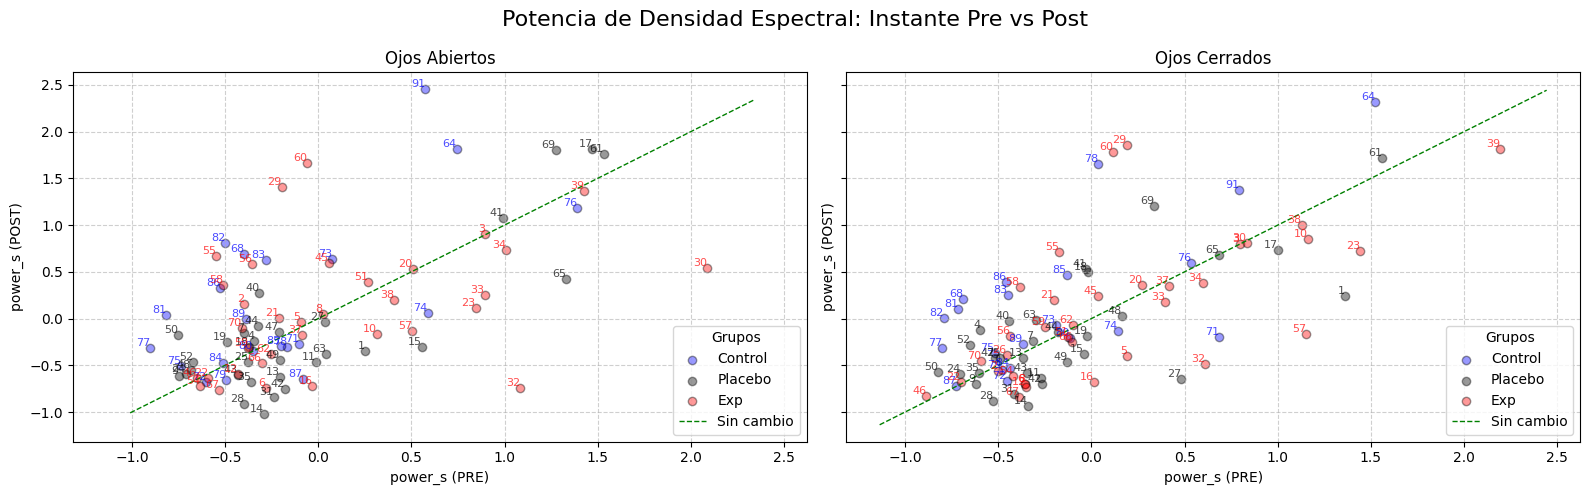

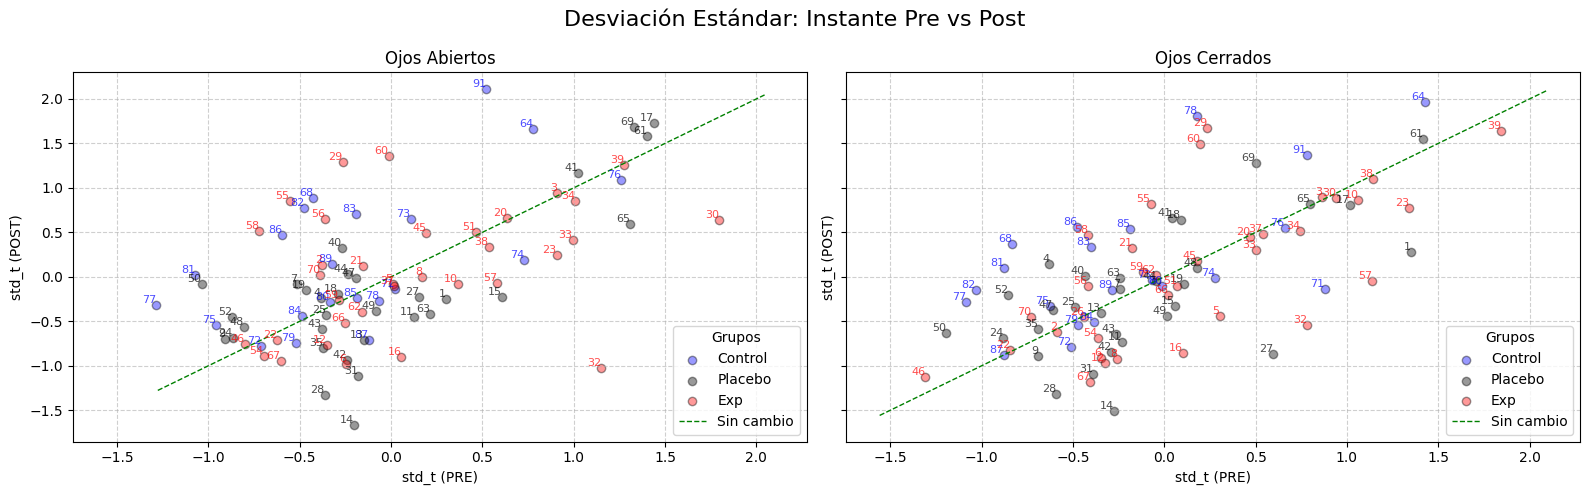

In [7]:
# OA: por cada sujeto promediamos todas las componentes y obtenemos un punto por sujeto
oa_pre = Utils.reset_cols_order(ML.compute_mean(df_oa_pre, nCol=3 , group_by = ["id", "grupo"]), N=2)
oa_post = Utils.reset_cols_order(ML.compute_mean(df_oa_post, nCol=3 , group_by = ["id", "grupo"]), N=2)

# OC: por cada sujeto promediamos todas las componentes y obtenemos un punto por sujeto
oc_pre = Utils.reset_cols_order(ML.compute_mean(df_oc_pre, nCol=3 , group_by = ["id", "grupo"]), N=2)
oc_post = Utils.reset_cols_order(ML.compute_mean(df_oc_post, nCol=3 , group_by = ["id", "grupo"]), N=2)

# Graficamos los grupos en función de la Potencia de Densidad Espectral
ML.mean_plot({"oa":[oa_pre, oa_post], "oc": [oc_pre, oc_post]}, f = "power_s", bAverage = True, bID = True,
             groups = ["Control", "Placebo", "Exp"], c = ["b","black","r"], 
             title = "Potencia de Densidad Espectral: Instante Pre vs Post", text = ["power_s (PRE)", "power_s (POST)"], 
             a = [0.4, 0.4, 0.4])

# Graficamos los grupos en función de la Desviación Estándar
ML.mean_plot({"oa":[oa_pre, oa_post], "oc": [oc_pre, oc_post]}, f = "std_t", bAverage = True, bID = True,
             groups = ["Control", "Placebo", "Exp"], c = ["b","black","r"], 
             title = "Desviación Estándar: Instante Pre vs Post", text = ["std_t (PRE)", "std_t (POST)"], 
             a = [0.4, 0.4, 0.4])

### Cálculo del Componente Promedio a partir de N Sujetos

Dentro de cada DataFrame, seleccionamos las componentes C1, C2, C3, ..., C20. Si cada componente refleja la actividad de N sujetos, calculamos una "componente" promedio. Es decir, para cada instante PRE y POST, aplicamos:
 $$Grupo_{j}:\  \overline{Cx}_{n}=\frac{1}{N_{j}}\sum^{N_{j}}_{i=1}{({Cx_{n}}^{i})},\ donde:$$

- $N_{j}$: es el número de sujetos dentro del grupo '$j$'.
- $i,j$: índices de referencia al sujeto '$i$' dentro del grupo '$j$'.
- ${Cx_{n}}^{i}$: es la característica extraída de la componente '$n$' del sujeto '$i$' en el grupo '$j$'.

Ahora tenemos N componentes de ICA para los grupos Control, Placebo y Experimento. Las filas ya no representan sujetos, sino componentes de ICA promediados, donde cada componente condensa la información de un grupo completo.

$$PRE$$
$$
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{ch}  & \textbf{grupo} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{PRE} & \text{$C_{1}$} & \text{Control} & \text{$\bar{Cx}_{1}$} & \text{$\bar{Cy}_{1}$} \\
\hline
\text{PRE} & \text{$C_{2}$} & \text{Control} & \text{$\bar{Cx}_{2}$} & \text{$\bar{Cy}_{2}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{PRE} & \text{$C_{1}$} & \text{Placebo} & \text{$\bar{Cx}_{1}$} & \text{$\bar{Cy}_{1}$} \\
\hline
\text{PRE} & \text{$C_{2}$} & \text{Placebo} & \text{$\bar{Cx}_{2}$} & \text{$\bar{Cy}_{2}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{PRE} & \text{$C_{1}$} & \text{Exp} & \text{$\bar{Cx}_{1}$} & \text{$\bar{Cy}_{1}$} \\
\hline
\text{PRE} & \text{$C_{2}$} & \text{Exp} & \text{$\bar{Cx}_{2}$} & \text{$\bar{Cy}_{2}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$
$$POST$$
$$
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{ch}  & \textbf{grupo} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{POST} & \text{$C_{1}$} & \text{Control} & \text{$\bar{Cx}_{1}$} & \text{$\bar{Cy}_{1}$} \\
\hline
\text{POST} & \text{$C_{2}$} & \text{Control} & \text{$\bar{Cx}_{2}$} & \text{$\bar{Cy}_{2}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{POST} & \text{$C_{1}$} & \text{Placebo} & \text{$\bar{Cx}_{1}$} & \text{$\bar{Cy}_{1}$} \\
\hline
\text{POST} & \text{$C_{2}$} & \text{Placebo} & \text{$\bar{Cx}_{2}$} & \text{$\bar{Cy}_{2}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{POST} & \text{$C_{1}$} & \text{Exp} & \text{$\bar{Cx}_{1}$} & \text{$\bar{Cy}_{1}$} \\
\hline
\text{POST} & \text{$C_{2}$} & \text{Exp} & \text{$\bar{Cx}_{2}$} & \text{$\bar{Cy}_{2}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

- En ojos abiertos:
    - Seleccionamos el instante PRE y POST por separado.
    - En cada instante hay 3 grupos: Control, Placebo y Experimental.
    - Dentro de cada grupo hay 19 componentes promedio.
    
- En ojos cerrados:
    - Seleccionamos el instante PRE y POST por separado.
    - En cada instante hay 3 grupos: Control, Placebo y Experimental.
    - Dentro de cada grupo hay 20 componentes promedio.

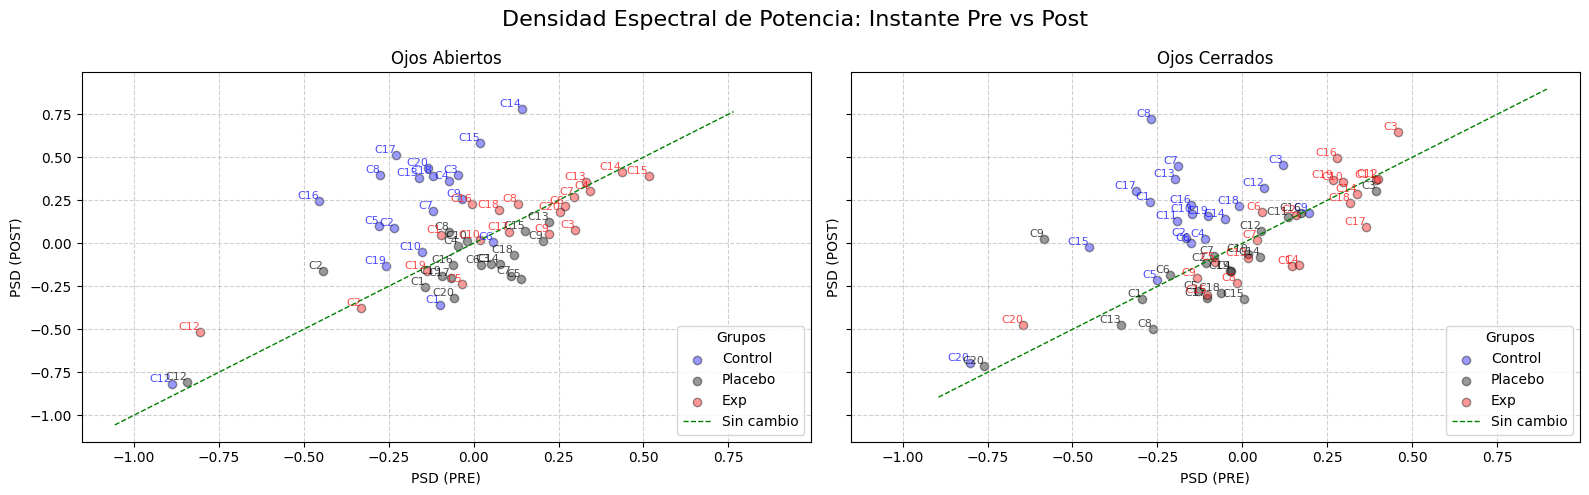

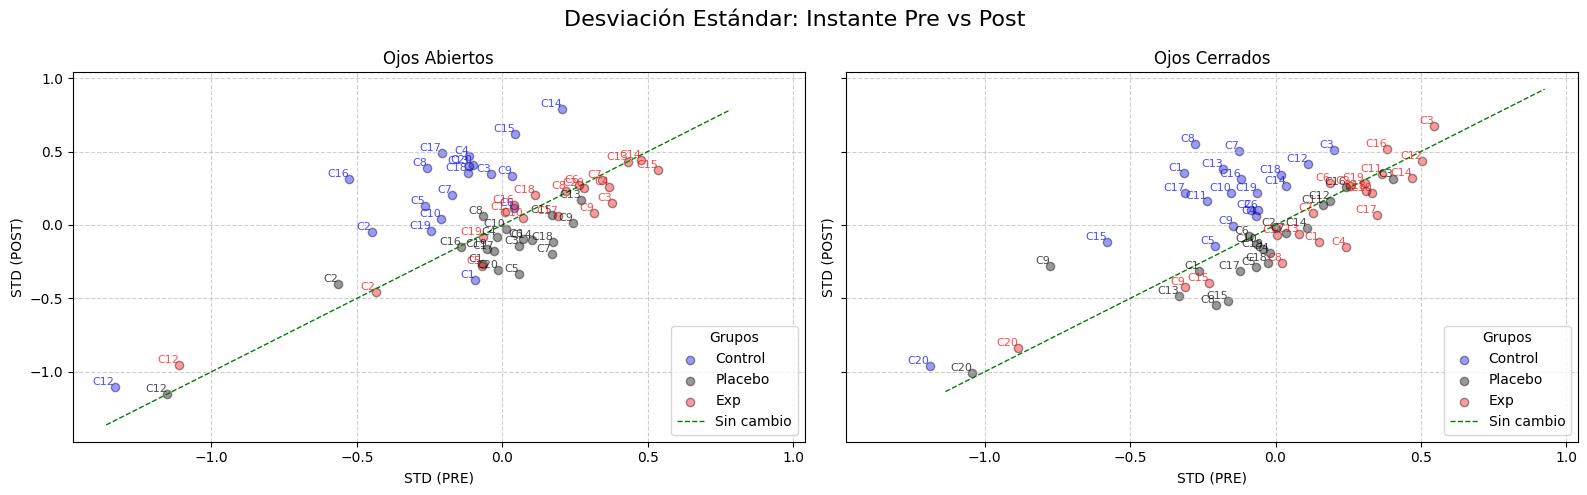

In [8]:
# OA: por cada grupo, seleccionamos todos los sujetos dentro de cada componente y los promediamos, obteniendo un punto por componente.
oa_pre = Utils.reset_cols_order(ML.compute_mean(df_oa_pre, nCol=3 , group_by = ["ch", "grupo"]), N=2)
oa_post = Utils.reset_cols_order(ML.compute_mean(df_oa_post, nCol=3 , group_by = ["ch", "grupo"]), N=2)

# OC: por cada grupo, seleccionamos todos los sujetos dentro de cada componente y los promediamos, obteniendo un punto por componente.
oc_pre = Utils.reset_cols_order(ML.compute_mean(df_oc_pre, nCol=3 , group_by = ["ch", "grupo"]), N=2)
oc_post = Utils.reset_cols_order(ML.compute_mean(df_oc_post, nCol=3 , group_by = ["ch", "grupo"]), N=2)

import matplotlib.pyplot as plt



# Graficamos los grupos en función de la Potencia de Densidad Espectral
ML.mean_plot({"oa":[oa_pre, oa_post], "oc": [oc_pre, oc_post]}, f = "power_s", bAverage = True, bID = True,
             groups = ["Control", "Placebo", "Exp"], c = ["b","black","r"], 
             title = "Densidad Espectral de Potencia: Instante Pre vs Post", text = ["PSD (PRE)", "PSD (POST)"], 
             a = [0.4, 0.4, 0.4])

# Graficamos los grupos en función de la Desviación Estándar
ML.mean_plot({"oa":[oa_pre, oa_post], "oc": [oc_pre, oc_post]}, f = "std_t", bAverage = True, bID = True,
             groups = ["Control", "Placebo", "Exp"], c = ["b","black","r"], 
             title = "Desviación Estándar: Instante Pre vs Post", text = ["STD (PRE)", "STD (POST)"], 
             a = [0.4, 0.4, 0.4])

**¡Razonamiento!**

Las componentes de ICA representan fuentes de información independientes, al promediar todas las componentes de cada sujeto, estamos perdiendo la estructura independiente de cada fuente y mezclando señales que deberían analizarse separadamente.

Cada componente tiene un significado propio, relacionado con una fuente específica de la actividad cerebral. Promediar todas las componentes de un sujeto destruye esa independencia, ya que combinamos fuentes que pueden poseer dinámicas diferentes.

Cuando promediamos los sujetos dentro de cada componente, obtenemos un resumen del comportamiento cerebral promedio de cada grupo sin perder la independencia de las fuentes de ICA. Además, no eliminamos la relación temporal porque tenemos en cuenta el instante PRE y POST en forma de características.

### Combinación de Instantes

Volvemos al DataFrame original con la siguiente disposición:

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{PRE} & \text{1} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{POST} & \text{25} & \text{Exp} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_1$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_2$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{SEG} & \text{87} & \text{Control} & \text{$C_3$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

Ahora, en vez de utilizar un DataFrame por cada instante de tiempo, vamos a combinarlos en un único DataFrame. Las características serán añadidas en las columnas con el identificador del instante al que pertencen.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{C1} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C2} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C3} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Exp} & \text{C1} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Exp} & \text{C2} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Exp} & \text{C3} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Control} & \text{C1}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Control} & \text{C2}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Control} & \text{C3}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

Como primera aproximación, puede ser interesante graficar el cambio $\Delta$ POST-PRE de los sujetos mediante la diferencia de sus características. Posteriormente, aplicamos una normalización sobre las características '$\Delta std_{t}$' y '$\Delta power_{s}$' mediante una Z-score, estandarizando por separado las columnas.

$$
\begin{array}{|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$\Delta std_{t}$} & \textbf{$\Delta power_{s}$} \\
\hline
\text{1} & \text{Control} & \text{C1} & \text{$\Delta x_{1}$} & \text{$\Delta y_{1}$} \\
\hline
\text{1} & \text{Control} & \text{C2} & \text{$\Delta x_{1}$} & \text{$\Delta y_{1}$} \\
\hline
\text{1} & \text{Control} & \text{C3} & \text{$\Delta x_{1}$} & \text{$\Delta y_{1}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{25} & \text{Placebo} & \text{C1} & \text{$\Delta x_{25}$} & \text{$\Delta y_{25}$} \\
\hline
\text{25} & \text{Placebo} & \text{C2} & \text{$\Delta x_{25}$} & \text{$\Delta y_{25}$} \\
\hline
\text{25} & \text{Placebo} & \text{C3} & \text{$\Delta x_{25}$} & \text{$\Delta y_{25}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{87} & \text{Exp} & \text{C1} & \text{$\Delta x_{87}$} & \text{$\Delta y_{87}$} \\
\hline
\text{87} & \text{Exp} & \text{C2} & \text{$\Delta x_{87}$} & \text{$\Delta y_{87}$} \\
\hline
\text{87} & \text{Exp} & \text{C3} & \text{$\Delta x_{87}$} & \text{$\Delta y_{87}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

In [9]:
df_oa_pre, df_oa_post = Utils.group_by(df_oa, col = "instante", val = ["PRE", "POST"])
df_oc_pre, df_oc_post = Utils.group_by(df_oc, col = "instante", val = ["PRE", "POST"])

# Select common subjects in PRE and POST -> columns = ['instante', 'ch', 'id', 'grupo', 'std_t', 'power_s']
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)

# Ignoramos columna 'instante' y restamos DataFrames a partir de la nCol = 3
df_diff_oa = Utils.merge_or_diff(df_oa_post.iloc[:,1:], df_oa_pre.iloc[:, 1:], nCol=3, option="diff")
df_diff_oc = Utils.merge_or_diff(df_oc_post.iloc[:,1:], df_oc_pre.iloc[:,1:], nCol=3, option="diff")

df_diff_oa_norm = Utils.reset_cols_order(ML.compute_mean(ML.normalize(df_diff_oa, N=3), nCol=3 , group_by = ["id", "grupo"]), N=2)
df_diff_oc_norm = Utils.reset_cols_order(ML.compute_mean(ML.normalize(df_diff_oc, N=3), nCol=3 , group_by = ["id", "grupo"]), N=2)

#### Cálculo del Sujeto Promedio a partir de 19/20 Componentes

Seleccionamos los grupos CTRL, PLCB y EXP, donde cada sujeto aparece repetido N veces (N = nº de componentes de ICA) y calculamos un "sujeto" promedio. Es decir, para cada grupo aplicamos:

$$Grupo_{j}:\  \overline{\Delta x}_{i}=\frac{1}{N}\sum^{N}_{n=0}{(\Delta x_{Cn}^{i})},\ donde:$$

- $N$: es el número de componentes de ICA (Análisis de Componentes Independientes).
- $i$: es el identificador correspondiente a cada sujeto.
- $j$: es el grupo correspondiente a cada sujeto.
- $\Delta x_{Cn}^{i}$: es la diferencia extraída de la componente '$n$' de ICA para el sujeto '$i$' en el grupo '$j$'.

Ahora, cada sujeto aparece exactamente una vez por grupo, siendo este un promedio de sus componentes.

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{$\Delta std_{t}$} & \textbf{$\Delta power_{s}$} \\
\hline
\text{1} & \text{Control} & \text{$\overline{\Delta x_{1}}$} & \text{$\overline{\Delta y_{1}}$} \\
\hline
\text{2} & \text{Control} & \text{$\overline{\Delta x_{2}}$} & \text{$\overline{\Delta y_{2}}$} \\
\hline
\text{3} & \text{Control} & \text{$\overline{\Delta x_{3}}$} & \text{$\overline{\Delta y_{3}}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{25} & \text{Placebo} & \text{$\overline{\Delta x_{25}}$} & \text{$\overline{\Delta y_{25}}$} \\
\hline
\text{26} & \text{Placebo} & \text{$\overline{\Delta x_{26}}$} & \text{$\overline{\Delta y_{26}}$} \\
\hline
\text{27} & \text{Placebo} & \text{$\overline{\Delta x_{27}}$} & \text{$\overline{\Delta y_{27}}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{87} & \text{Exp} & \text{$\overline{\Delta x_{87}}$} & \text{$\overline{\Delta y_{87}}$} \\
\hline
\text{88} & \text{Exp} & \text{$\overline{\Delta x_{88}}$} & \text{$\overline{\Delta y_{88}}$} \\
\hline
\text{89} & \text{Exp} & \text{$\overline{\Delta x_{89}}$} & \text{$\overline{\Delta y_{89}}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

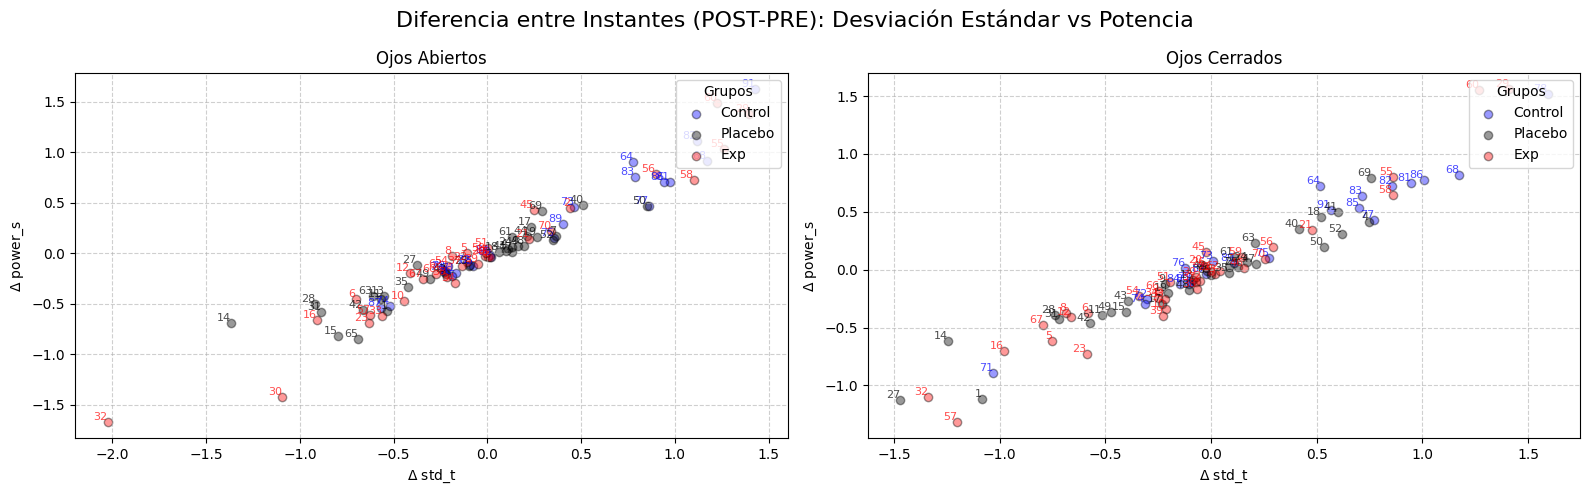

In [10]:
ML.mean_diff_plot({"oa": df_diff_oa_norm, "oc": df_diff_oc_norm}, f = ["std_t","power_s"], bAverage = True, bID = True,
                    groups = ["Control", "Placebo", "Exp"], c = ["b","black","r"], 
                    title = "Diferencia entre Instantes (POST-PRE): Desviación Estándar vs Potencia", 
                    text = ["$\\Delta$ std_t", "$\\Delta$ power_s"], 
                    a = [0.4, 0.4, 0.4])

#### Cálculo del Componente Promedio a partir de N Sujetos

Seleccionamos las componentes C1, C2, C3, ..., C20. Si cada componente refleja la actividad de N sujetos, calculamos una "componente" promedio. Es decir, para cada grupo, aplicamos:
 $$Grupo_{j}:\  \overline{Cx}_{n}=\frac{1}{N_{j}}\sum^{N_{j}}_{i=1}{({Cx_{n}}^{i})},\ donde:$$

- $N_{j}$: es el número de sujetos dentro del grupo '$j$'.
- $i,j$: índices de referencia al sujeto '$i$' dentro del grupo '$j$'.
- ${Cx_{n}}^{i}$: es la característica extraída de la componente '$n$' del sujeto '$i$' en el grupo '$j$'.

Ahora tenemos N componentes de ICA para los grupos Control, Placebo y Experimento. Las filas ya no representan sujetos, sino componentes de ICA promediados, donde cada componente condensa la información de un grupo completo.

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{ch}  & \textbf{grupo} & \textbf{$\Delta std_{t}$} & \textbf{$\Delta power_{s}$} \\
\hline
\text{$C_{1}$} & \text{Control} & \text{$\overline{\Delta Cx_{1}}$} & \text{$\overline{\Delta Cy_{1}}$} \\
\hline
\text{$C_{2}$} & \text{Control} & \text{$\overline{\Delta Cx_{2}}$} & \text{$\overline{\Delta Cy_{2}}$} \\
\hline
\text{$C_{3}$} & \text{Control} & \text{$\overline{\Delta Cx_{3}}$} & \text{$\overline{\Delta Cy_{3}}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{$C_{1}$} & \text{Placebo} & \text{$\overline{\Delta Cx_{1}}$} & \text{$\overline{\Delta Cy_{1}}$} \\
\hline
\text{$C_{2}$} & \text{Placebo} & \text{$\overline{\Delta Cx_{2}}$} & \text{$\overline{\Delta Cy_{2}}$} \\
\hline
\text{$C_{3}$} & \text{Placebo} & \text{$\overline{\Delta Cx_{3}}$} & \text{$\overline{\Delta Cy_{3}}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{$C_{1}$} & \text{Exp} & \text{$\overline{\Delta Cx_{1}}$} & \text{$\overline{\Delta Cy_{1}}$} \\
\hline
\text{$C_{2}$} & \text{Exp} & \text{$\overline{\Delta Cx_{2}}$} & \text{$\overline{\Delta Cy_{2}}$} \\
\hline
\text{$C_{3}$} & \text{Exp} & \text{$\overline{\Delta Cx_{3}}$} & \text{$\overline{\Delta Cy_{3}}$} \\
\hline
\text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

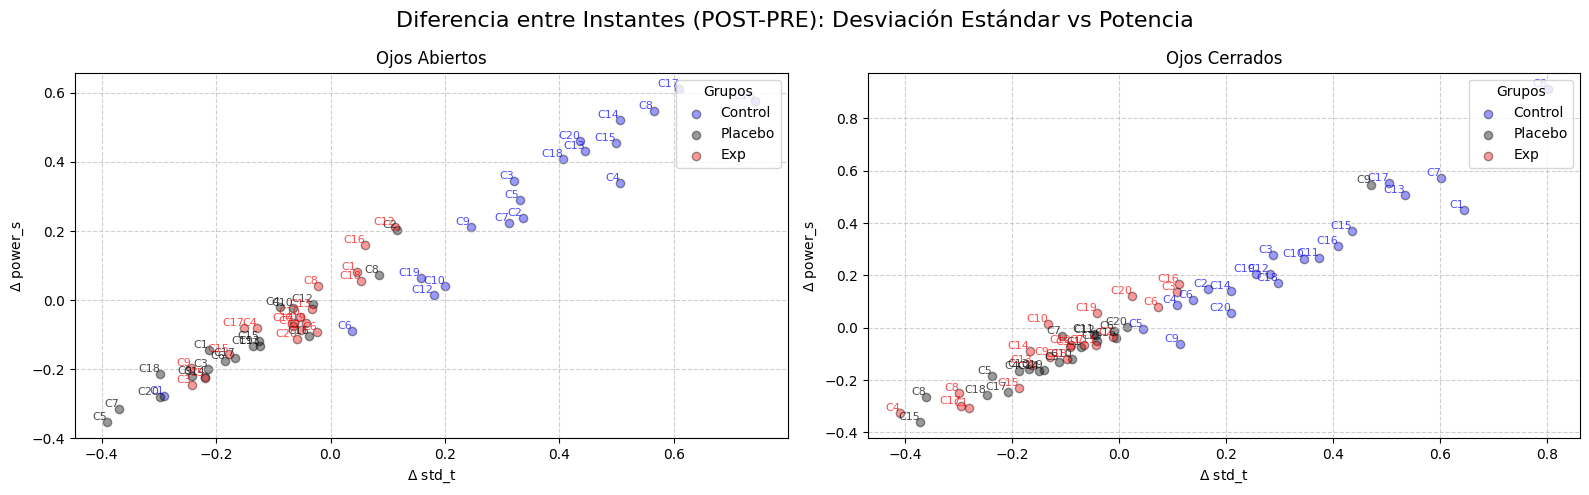

In [11]:
df_diff_oa_norm = Utils.reset_cols_order(ML.compute_mean(ML.normalize(df_diff_oa, N=3), nCol=3 , group_by = ["ch", "grupo"]), N=2)
df_diff_oc_norm = Utils.reset_cols_order(ML.compute_mean(ML.normalize(df_diff_oc, N=3), nCol=3 , group_by = ["ch", "grupo"]), N=2)

ML.mean_diff_plot({"oa": df_diff_oa_norm, "oc": df_diff_oc_norm}, f = ["std_t","power_s"], bAverage = True, bID = True,
                    groups = ["Control", "Placebo", "Exp"], c = ["b","black","r"], 
                    title = "Diferencia entre Instantes (POST-PRE): Desviación Estándar vs Potencia", 
                    text = ["$\\Delta$ std_t", "$\\Delta$ power_s"], 
                    a = [0.4, 0.4, 0.4])

## Regresión Logistica

In [12]:
# Gather all .csv files from each path
all_temp_oa_csv, all_spec_oa_csv = Utils.get_files(data_OA_paths[0]+"\\"+bands[0]), Utils.get_files(data_OA_paths[1]+"\\"+bands[0])
all_temp_oc_csv, all_spec_oc_csv = Utils.get_files(data_OC_paths[0]+"\\"+bands[0]), Utils.get_files(data_OC_paths[1]+"\\"+bands[0])

# Loading all information by concatenating PRE, POST, and SEG DataFrames
df_temp_oa, df_spec_oa = Utils.read_file_csv(all_temp_oa_csv), Utils.read_file_csv(all_spec_oa_csv)
df_temp_oc, df_spec_oc = Utils.read_file_csv(all_temp_oc_csv), Utils.read_file_csv(all_spec_oc_csv)

# Reset info columns order -> Movemos la columna "Var" hacia el final
df_temp_oa, df_spec_oa = Utils.reset_cols_order(df_temp_oa, N=4), Utils.reset_cols_order(df_spec_oa, N=4)
df_temp_oc, df_spec_oc = Utils.reset_cols_order(df_temp_oc, N=4), Utils.reset_cols_order(df_spec_oc, N=4)

# Rename features for both domains -> Colocamos 't' o 's' dependiendo del dominio
df_temp_oa, df_spec_oa = Utils.rename_feats(df_temp_oa, nCol=4, val="t"), Utils.rename_feats(df_spec_oa, nCol=4, val="s")
df_temp_oc, df_spec_oc = Utils.rename_feats(df_temp_oc, nCol=4, val="t"), Utils.rename_feats(df_spec_oc, nCol=4, val="s")

N = len(df_temp_oa.columns[4:])

# Realizamos un join usando las 4 primeras columnas como clave 
df_oa = pd.merge(df_temp_oa, df_spec_oa, on=list(df_temp_oa.columns)[:-N], how='inner')
df_oc = pd.merge(df_temp_oc, df_spec_oc, on=list(df_temp_oc.columns)[:-N], how='inner')

# Rename subjects for PLACEBO group
df_oa, df_oc = Utils.rename_subjects(df_oa, ids_placebos), Utils.rename_subjects(df_oc, ids_placebos)

# Remove noisy subjects
df_oa, df_oc  = Utils.remove_subjects(df_oa, ids_oa_removal), Utils.remove_subjects(df_oc, ids_oc_removal)

# Añadimos una columna 'tipo' que refleje si son datos de ojos abiertos (OA) o cerrados (OC).
df_oa = Utils.add_column(df_oa, col_name="tipo", val="OA", idx=0)
df_oc = Utils.add_column(df_oc, col_name="tipo", val="OC", idx=0)

### Cálculo del Sujeto Promedio

#### Ojos Abiertos/Cerrados

Procesamos los datasets de ojos abiertos y cerrados por separado, ya que van a ser los inputs 1 y 2 en el modelo de regresión logística. Posteriormente, aplicamos una normalización sobre las características '$std_{t}$' y '$power_{s}$' mediante una Z-score.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$


Ahora, aplicamos el cálculo del sujeto promedio y obtenemos una fila por sujeto en ojos abiertos y cerrados. 

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{C1} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C2} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C3} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Placebo} & \text{C1} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C2} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C3} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Exp} & \text{C1}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C2}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C3}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{$\bar{x}_{1}'$} & \text{$\bar{y}_{1}'$} & \text{$\bar{x}_{1}''$} & \text{$\bar{y}_{1}''$}\\
\hline
\text{2} & \text{Control}& \text{$\bar{x}_{2}'$} & \text{$\bar{y}_{2}'$} & \text{$\bar{x}_{2}''$} & \text{$\bar{y}_{2}''$}\\
\hline
\text{3} & \text{Control}& \text{$\bar{x}_{3}'$} & \text{$\bar{y}_{3}'$} & \text{$\bar{x}_{3}''$} & \text{$\bar{y}_{3}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Exp}& \text{$\bar{x}_{25}'$} & \text{$\bar{y}_{25}'$} & \text{$\bar{x}_{25}''$} & \text{$\bar{y}_{25}''$}\\
\hline
\text{26} & \text{Exp}& \text{$\bar{x}_{26}'$} & \text{$\bar{y}_{26}'$} & \text{$\bar{x}_{26}''$} & \text{$\bar{y}_{26}''$}\\
\hline
\text{27} & \text{Exp}& \text{$\bar{x}_{27}'$} & \text{$\bar{y}_{27}'$} & \text{$\bar{x}_{27}''$} & \text{$\bar{y}_{27}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Control} & \text{$\bar{x}_{87}'$} & \text{$\bar{y}_{87}'$} & \text{$\bar{x}_{87}''$} & \text{$\bar{y}_{87}''$}\\
\hline
\text{88} & \text{Control} & \text{$\bar{x}_{88}'$} & \text{$\bar{y}_{88}'$} & \text{$\bar{x}_{88}''$} & \text{$\bar{y}_{88}''$}\\
\hline
\text{89} & \text{Control} & \text{$\bar{x}_{89}'$} & \text{$\bar{y}_{89}'$} & \text{$\bar{x}_{89}''$} & \text{$\bar{y}_{89}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

Después de combinar características, obtenemos los DataFrames para ojos abiertos y cerrados que servirán como inputs 1 y 2, respectivamente. 

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{$std_{pre}^{OA}$} & \textbf{$power_{pre}^{OA}$} & \textbf{$std_{post}^{OA}$} & \textbf{$power_{post}^{OA}$} \\
\hline
\text{1} & \text{Control} & \text{$\bar{x}_{1}'$} & \text{$\bar{y}_{1}'$} & \text{$\bar{x}_{1}''$} & \text{$\bar{y}_{1}''$} \\
\hline
\text{2} & \text{Control}& \text{$\bar{x}_{2}'$} & \text{$\bar{y}_{2}'$} & \text{$\bar{x}_{2}''$} & \text{$\bar{y}_{2}''$} \\
\hline
\text{3} & \text{Control}& \text{$\bar{x}_{3}'$} & \text{$\bar{y}_{3}'$} & \text{$\bar{x}_{3}''$} & \text{$\bar{y}_{3}''$} \\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{25} & \text{Exp}& \text{$\bar{x}_{25}'$} & \text{$\bar{y}_{25}'$} & \text{$\bar{x}_{25}''$} & \text{$\bar{y}_{25}''$} \\
\hline
\text{26} & \text{Exp}& \text{$\bar{x}_{26}'$} & \text{$\bar{y}_{26}'$} & \text{$\bar{x}_{26}''$} & \text{$\bar{y}_{26}''$} \\
\hline
\text{27} & \text{Exp}& \text{$\bar{x}_{27}'$} & \text{$\bar{y}_{27}'$} & \text{$\bar{x}_{27}''$} & \text{$\bar{y}_{27}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{87} & \text{Control} & \text{$\bar{x}_{87}'$} & \text{$\bar{y}_{87}'$} & \text{$\bar{x}_{87}''$} & \text{$\bar{y}_{87}''$} \\
\hline
\text{88} & \text{Control} & \text{$\bar{x}_{88}'$} & \text{$\bar{y}_{88}'$} & \text{$\bar{x}_{88}''$} & \text{$\bar{y}_{88}''$} \\
\hline
\text{89} & \text{Control} & \text{$\bar{x}_{89}'$} & \text{$\bar{y}_{89}'$} & \text{$\bar{x}_{89}''$} & \text{$\bar{y}_{89}''$} \\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{$std_{pre}^{OC}$} & \textbf{$power_{pre}^{OC}$} & \textbf{$std_{post}^{OC}$} & \textbf{$power_{post}^{OC}$} \\
\hline
\text{1} & \text{Control} & \text{$\bar{x}_{1}'$} & \text{$\bar{y}_{1}'$} & \text{$\bar{x}_{1}''$} & \text{$\bar{y}_{1}''$} \\
\hline
\text{2} & \text{Control}& \text{$\bar{x}_{2}'$} & \text{$\bar{y}_{2}'$} & \text{$\bar{x}_{2}''$} & \text{$\bar{y}_{2}''$} \\
\hline
\text{3} & \text{Control}& \text{$\bar{x}_{3}'$} & \text{$\bar{y}_{3}'$} & \text{$\bar{x}_{3}''$} & \text{$\bar{y}_{3}''$} \\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{25} & \text{Exp}& \text{$\bar{x}_{25}'$} & \text{$\bar{y}_{25}'$} & \text{$\bar{x}_{25}''$} & \text{$\bar{y}_{25}''$} \\
\hline
\text{26} & \text{Exp}& \text{$\bar{x}_{26}'$} & \text{$\bar{y}_{26}'$} & \text{$\bar{x}_{26}''$} & \text{$\bar{y}_{26}''$} \\
\hline
\text{27} & \text{Exp}& \text{$\bar{x}_{27}'$} & \text{$\bar{y}_{27}'$} & \text{$\bar{x}_{27}''$} & \text{$\bar{y}_{27}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\text{87} & \text{Control} & \text{$\bar{x}_{87}'$} & \text{$\bar{y}_{87}'$} & \text{$\bar{x}_{87}''$} & \text{$\bar{y}_{87}''$} \\
\hline
\text{88} & \text{Control} & \text{$\bar{x}_{88}'$} & \text{$\bar{y}_{88}'$} & \text{$\bar{x}_{88}''$} & \text{$\bar{y}_{88}''$} \\
\hline
\text{89} & \text{Control} & \text{$\bar{x}_{89}'$} & \text{$\bar{y}_{89}'$} & \text{$\bar{x}_{89}''$} & \text{$\bar{y}_{89}''$} \\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} \\
\hline
\end{array}
$$

In [13]:
# Normalize
df_oa_norm, df_oc_norm = ML.normalize(df_oa, N=5), ML.normalize(df_oc, N=5)

# Obtenemos 2 DataFrames: uno por cada instante
df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm, col = "instante", val = ["PRE", "POST"])
df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm, col = "instante", val = ["PRE", "POST"])

# Rename features for both instants -> Colocamos 'pre' o 'post' dependiendo del instante
df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=5, val="pre"), Utils.rename_feats(df_oa_post, nCol=5, val="post")
df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=5, val="pre"), Utils.rename_feats(df_oc_post, nCol=5, val="post")

# Select common subjects in PRE and POST
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

# Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'tipo' e 'instante'
df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,2:], df_oa_pre.iloc[:, 2:], nCol=3, option="merge")
df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,2:], df_oc_pre.iloc[:, 2:], nCol=3, option="merge")

# Calculamos el sujeto promedio y tenemos una fila por sujeto -> columns = ['id', 'grupo', 'std_t_pre', 'power_s_pre', 'std_t_post', 'power_s_post']
oa_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oa, nCol = 3, group_by = ["id", "grupo"]), N=2)
oc_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oc, nCol = 3, group_by = ["id", "grupo"]), N=2)

# Input 1: ojos abiertos
X_oa = oa_merge.iloc[:,2:].values
y_oa = oa_merge["grupo"].values

# Input 2: ojos cerrados
X_oc = oc_merge.iloc[:,2:].values
y_oc = oc_merge["grupo"].values

#### Ojos Abiertos y Cerrados


Construimos un dataset que combine los sujetos de ojos abiertos y cerrados, ya que va a ser el input 3 del modelo de regresión logística. Posteriormente, aplicamos una normalización sobre las características '$std_{t}$' y '$power_{s}$' mediante una Z-score.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$

Ahora, aplicamos el cálculo del sujeto promedio en el dataset de ojos abiertos y cerrados por separado, lo que resulta en una fila por sujeto en ambos DataFrames. 

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{C1} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C2} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C3} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Placebo} & \text{C1} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C2} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C3} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Exp} & \text{C1}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C2}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C3}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{$\bar{x}_{1}'$} & \text{$\bar{y}_{1}'$} & \text{$\bar{x}_{1}''$} & \text{$\bar{y}_{1}''$}\\
\hline
\text{2} & \text{Control}& \text{$\bar{x}_{2}'$} & \text{$\bar{y}_{2}'$} & \text{$\bar{x}_{2}''$} & \text{$\bar{y}_{2}''$}\\
\hline
\text{3} & \text{Control}& \text{$\bar{x}_{3}'$} & \text{$\bar{y}_{3}'$} & \text{$\bar{x}_{3}''$} & \text{$\bar{y}_{3}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Exp}& \text{$\bar{x}_{25}'$} & \text{$\bar{y}_{25}'$} & \text{$\bar{x}_{25}''$} & \text{$\bar{y}_{25}''$}\\
\hline
\text{26} & \text{Exp}& \text{$\bar{x}_{26}'$} & \text{$\bar{y}_{26}'$} & \text{$\bar{x}_{26}''$} & \text{$\bar{y}_{26}''$}\\
\hline
\text{27} & \text{Exp}& \text{$\bar{x}_{27}'$} & \text{$\bar{y}_{27}'$} & \text{$\bar{x}_{27}''$} & \text{$\bar{y}_{27}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Control} & \text{$\bar{x}_{87}'$} & \text{$\bar{y}_{87}'$} & \text{$\bar{x}_{87}''$} & \text{$\bar{y}_{87}''$}\\
\hline
\text{88} & \text{Control} & \text{$\bar{x}_{88}'$} & \text{$\bar{y}_{88}'$} & \text{$\bar{x}_{88}''$} & \text{$\bar{y}_{88}''$}\\
\hline
\text{89} & \text{Control} & \text{$\bar{x}_{89}'$} & \text{$\bar{y}_{89}'$} & \text{$\bar{x}_{89}''$} & \text{$\bar{y}_{89}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

Concatenamos las características por columnas y obtenemos la distribución que servirá como input 3.

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{$std_{pre}^{OA}$} & \textbf{$power_{pre}^{OA}$} & \textbf{$std_{post}^{OA}$} & \textbf{$power_{post}^{OA}$}& \textbf{$std_{pre}^{OC}$} & \textbf{$power_{pre}^{OC}$} & \textbf{$std_{post}^{OC}$} & \textbf{$power_{post}^{OC}$} \\
\hline
\text{1} & \text{Control} & \text{$\bar{x}_{1}'$} & \text{$\bar{y}_{1}'$} & \text{$\bar{x}_{1}''$} & \text{$\bar{y}_{1}''$} & \text{$\bar{x}_{1}'$} & \text{$\bar{y}_{1}'$} & \text{$\bar{x}_{1}''$} & \text{$\bar{y}_{1}''$}\\
\hline
\text{2} & \text{Control}& \text{$\bar{x}_{2}'$} & \text{$\bar{y}_{2}'$} & \text{$\bar{x}_{2}''$} & \text{$\bar{y}_{2}''$} & \text{$\bar{x}_{2}'$} & \text{$\bar{y}_{2}'$} & \text{$\bar{x}_{2}''$} & \text{$\bar{y}_{2}''$}\\
\hline
\text{3} & \text{Control}& \text{$\bar{x}_{3}'$} & \text{$\bar{y}_{3}'$} & \text{$\bar{x}_{3}''$} & \text{$\bar{y}_{3}''$} & \text{$\bar{x}_{3}'$} & \text{$\bar{y}_{3}'$} & \text{$\bar{x}_{3}''$} & \text{$\bar{y}_{3}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Exp}& \text{$\bar{x}_{25}'$} & \text{$\bar{y}_{25}'$} & \text{$\bar{x}_{25}''$} & \text{$\bar{y}_{25}''$} & \text{$\bar{x}_{25}'$} & \text{$\bar{y}_{25}'$} & \text{$\bar{x}_{25}''$} & \text{$\bar{y}_{25}''$}\\
\hline
\text{26} & \text{Exp}& \text{$\bar{x}_{26}'$} & \text{$\bar{y}_{26}'$} & \text{$\bar{x}_{26}''$} & \text{$\bar{y}_{26}''$} & \text{$\bar{x}_{26}'$} & \text{$\bar{y}_{26}'$} & \text{$\bar{x}_{26}''$} & \text{$\bar{y}_{26}''$}\\
\hline
\text{27} & \text{Exp}& \text{$\bar{x}_{27}'$} & \text{$\bar{y}_{27}'$} & \text{$\bar{x}_{27}''$} & \text{$\bar{y}_{27}''$} & \text{$\bar{x}_{27}'$} & \text{$\bar{y}_{27}'$} & \text{$\bar{x}_{27}''$} & \text{$\bar{y}_{27}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Control} & \text{$\bar{x}_{87}'$} & \text{$\bar{y}_{87}'$} & \text{$\bar{x}_{87}''$} & \text{$\bar{y}_{87}''$} & \text{$\bar{x}_{87}'$} & \text{$\bar{y}_{87}'$} & \text{$\bar{x}_{87}''$} & \text{$\bar{y}_{87}''$}\\
\hline
\text{88} & \text{Control} & \text{$\bar{x}_{88}'$} & \text{$\bar{y}_{88}'$} & \text{$\bar{x}_{88}''$} & \text{$\bar{y}_{88}''$} & \text{$\bar{x}_{88}'$} & \text{$\bar{y}_{88}'$} & \text{$\bar{x}_{88}''$} & \text{$\bar{y}_{88}''$}\\
\hline
\text{89} & \text{Control} & \text{$\bar{x}_{89}'$} & \text{$\bar{y}_{89}'$} & \text{$\bar{x}_{89}''$} & \text{$\bar{y}_{89}''$} & \text{$\bar{x}_{89}'$} & \text{$\bar{y}_{89}'$} & \text{$\bar{x}_{89}''$} & \text{$\bar{y}_{89}''$}\\
\hline
\text{...} & \text{...}& \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

In [14]:
# Concatenamos DataFrames (merge by rows) -> (axis = 0)
df_oa_oc = Utils.merge_or_diff(df_oa, df_oc, nCol=0, option = "merge", by_axis=0)

# Normalizamos todo el conjunto
df_oa_oc_norm = ML.normalize(df_oa_oc, N=5)

# Recuperamos DataFrames de OA y OC para combinar características por columnas
df_oa_norm, df_oc_norm = Utils.group_by(df_oa_oc_norm, col="tipo", val=["OA","OC"])

# Obtenemos 2 DataFrames: uno por cada instante -> ignoramos columna 'tipo' (ya no es necesaria)
df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']
df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']

# Renombramos características de ambos 'instantes' -> Colocamos 'pre' o 'post' dependiendo del instante
df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=4, val="pre_oa"), Utils.rename_feats(df_oa_post, nCol=4, val="post_oa")
df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=4, val="pre_oc"), Utils.rename_feats(df_oc_post, nCol=4, val="post_oc")

# Select common subjects in PRE and POST
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

# Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'instante'
df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,1:], df_oa_pre.iloc[:, 1:], nCol=3, option="merge")
df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,1:], df_oc_pre.iloc[:, 1:], nCol=3, option="merge")

# Calculamos el sujeto promedio y tenemos una fila por sujeto -> columns = ['id', 'grupo', 'std_t_pre', 'power_s_pre', 'std_t_post', 'power_s_post']
oa_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oa, nCol = 3, group_by = ["id", "grupo"]), N=2)
oc_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oc, nCol = 3, group_by = ["id", "grupo"]), N=2)

# Seleccionamos sujetos comunes en ojos abiertos y cerrados
oa_merge, oc_merge = Utils.select_common_ids(oa_merge, oc_merge, sort_by=["id"])

# Realizamos un merge
oa_oc_merge = Utils.merge_or_diff(oa_merge, oc_merge, nCol=2, option="merge")

# Input 3: ojos abiertos y cerrados
X_oa_oc = oa_oc_merge.iloc[:,2:].values
y_oa_oc = oa_oc_merge["grupo"].values

#### Plots

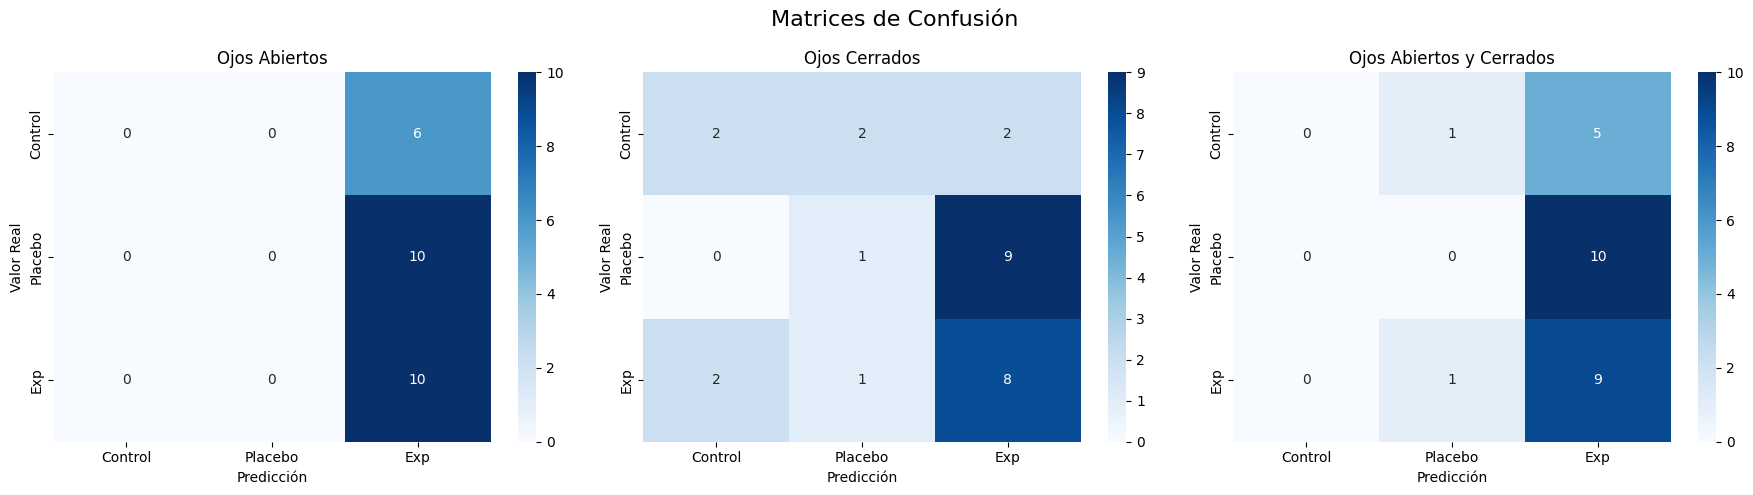

Best parameters: {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.38

Best parameters: {'C': 0.8, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.41

Best parameters: {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.35


In [15]:
# Combinamos los 3 inputs en un diccionario y se introduce al modelo LogReg()
dict_datasets = {"oa":[X_oa, y_oa],
                 "oc":[X_oc, y_oc],
                 "oa_oc":[X_oa_oc, y_oa_oc]}

# Realizamos clasificacion y ploteamos
report = ML.plot_log_reg(dict_datasets, class_names = ['Control', 'Placebo', 'Exp'], title = "Matrices de Confusión", subtitle = ["Ojos Abiertos","Ojos Cerrados","Ojos Abiertos y Cerrados"])

print("Best parameters:",report["oa"]['best_params'])
print("Accuracy:", round(report["oa"]['accuracy'],2))
print()
print("Best parameters:",report["oc"]['best_params'])
print("Accuracy:", round(report["oc"]['accuracy'],2))
print()
print("Best parameters:",report["oa_oc"]['best_params'])
print("Accuracy:", round(report["oa_oc"]['accuracy'],2))

#### PCA

In [16]:
def transform_features(df, nCol, by_col):
    save = []
    for (ch), sub_df in df.groupby(by_col):

        new_cols = [f"{c}_"+ch for c in sub_df.columns[nCol:]]

        sub_df.columns = list(sub_df.columns)[:nCol]+new_cols

        # Descartamos la columna ch, no la necesitamos mas
        sub_df = sub_df.loc[:, sub_df.columns != by_col]

        save.append(sub_df.reset_index(drop=True))

    out = pd.concat(save, axis=1)

    return out.loc[:, ~out.columns.duplicated()]

In [17]:
# Concatenamos DataFrames (merge by rows) -> (axis = 0)
df_oa_oc = Utils.merge_or_diff(df_oa, df_oc, nCol=0, option = "merge", by_axis=0)

# Normalizamos todo el conjunto
df_oa_oc_norm = ML.normalize(df_oa_oc, N=5)

# Recuperamos DataFrames de OA y OC para combinar características por columnas
df_oa_norm, df_oc_norm = Utils.group_by(df_oa_oc_norm, col="tipo", val=["OA","OC"])

# Obtenemos 2 DataFrames: uno por cada instante -> ignoramos columna 'tipo' (ya no es necesaria)
df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']
df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']

# Renombramos características de ambos 'instantes' -> Colocamos 'pre' o 'post' dependiendo del instante
df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=4, val="pre_oa"), Utils.rename_feats(df_oa_post, nCol=4, val="post_oa")
df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=4, val="pre_oc"), Utils.rename_feats(df_oc_post, nCol=4, val="post_oc")

# Select common subjects in PRE and POST
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

# Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'instante'
df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,1:], df_oa_pre.iloc[:, 1:], nCol=3, option="merge")
df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,1:], df_oc_pre.iloc[:, 1:], nCol=3, option="merge")

df_merge_oa, df_merge_oc = Utils.select_common_ids(df_merge_oa, df_merge_oc, sort_by=["id","ch"])

# Transformamos nuestras caracteristicas de tal forma que ahora tenemos
# std_pre, std_post, power_pre y power_post por cada componente de ICA
# en las columnas, es decir, 4*20 caracteristicas. 
input_oa_pca = transform_features(df_merge_oa, nCol = 3, by_col='ch')
input_oc_pca = transform_features(df_merge_oc, nCol = 3, by_col='ch')
input_oa_oc_pca = Utils.merge_or_diff(input_oa_pca, input_oc_pca, nCol=2, option="merge", by_axis=1)


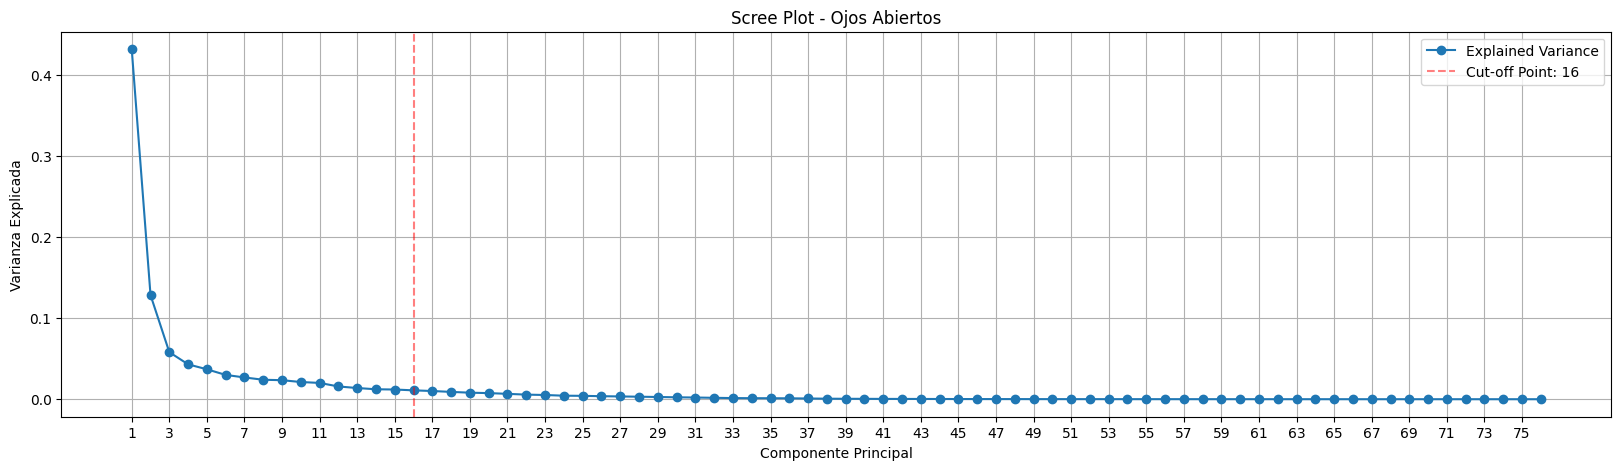

Número de componentes necesarios para alcanzar el 90% de varianza: 16


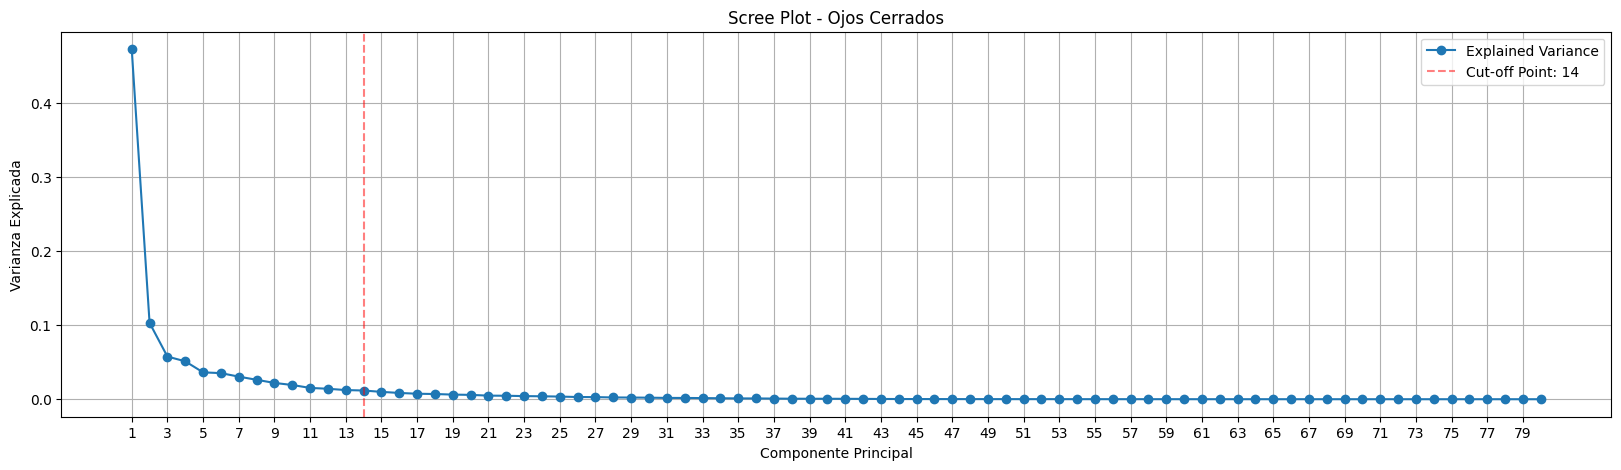

Número de componentes necesarios para alcanzar el 90% de varianza: 14


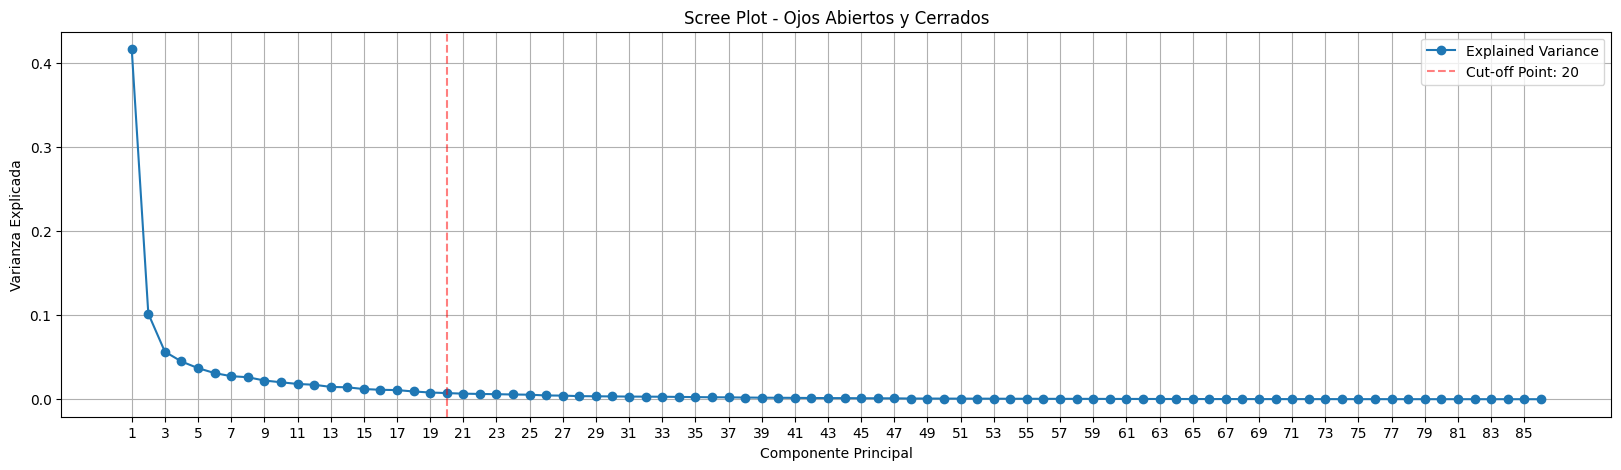

Número de componentes necesarios para alcanzar el 90% de varianza: 20


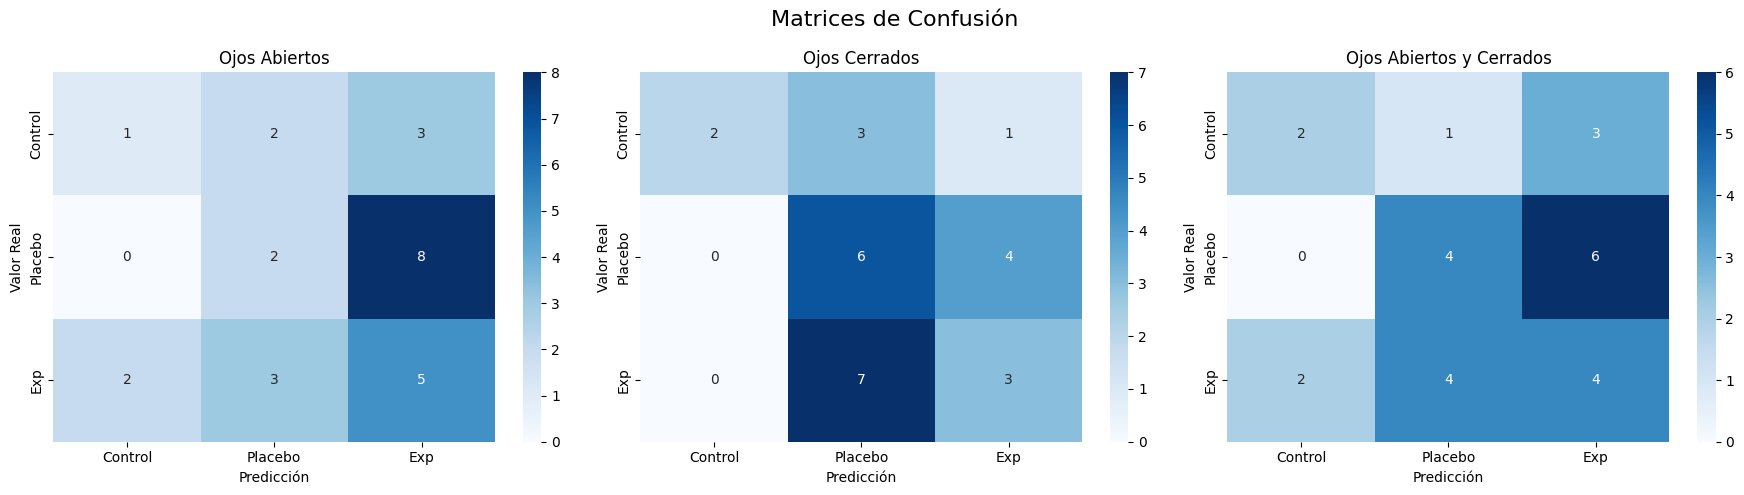

Best parameters: {'C': 0.06, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.31

Best parameters: {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.42

Best parameters: {'C': 0.02, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.38



In [18]:
import numpy as np
from sklearn.decomposition import PCA

# Crear el objeto PCA (por ejemplo, reducir a 2 componentes principales)
pca_oa = PCA()
pca_oc = PCA()
pca_oa_oc = PCA()

# Ajustar el modelo PCA a los datos
X_pca_oa = pca_oa.fit_transform(input_oa_pca.iloc[:,2:])
X_pca_oc = pca_oc.fit_transform(input_oc_pca.iloc[:,2:])
X_pca_oa_oc = pca_oa_oc.fit_transform(input_oa_oc_pca.iloc[:,2:])

# Numero de componentes que suman 0.9 de varianza explicada
num_comp_oa = np.argmax(np.cumsum(pca_oa.explained_variance_ratio_) >= 0.90)+1  # Se suma 1 porque el indice comienza desde 0
num_comp_oc = np.argmax(np.cumsum(pca_oc.explained_variance_ratio_) >= 0.90)+1  # Se suma 1 porque el indice comienza desde 0
num_comp_oa_oc = np.argmax(np.cumsum(pca_oa_oc.explained_variance_ratio_) >= 0.90)+1  # Se suma 1 porque el indice comienza desde 0

Plots.scree_plot(pca_oa.explained_variance_ratio_, point=num_comp_oa, title = 'Scree Plot - Ojos Abiertos', size = (20,5))
print(f'Número de componentes necesarios para alcanzar el 90% de varianza: {num_comp_oa}')

Plots.scree_plot(pca_oc.explained_variance_ratio_, point=num_comp_oc, title = 'Scree Plot - Ojos Cerrados', size = (20,5))
print(f'Número de componentes necesarios para alcanzar el 90% de varianza: {num_comp_oc}')

Plots.scree_plot(pca_oa_oc.explained_variance_ratio_, point=num_comp_oa_oc, title = 'Scree Plot - Ojos Abiertos y Cerrados', size = (20,5))
print(f'Número de componentes necesarios para alcanzar el 90% de varianza: {num_comp_oa_oc}')

# Combinamos los 3 inputs en un diccionario y se introduce al modelo LogReg()
dict_datasets = {"oa":[X_pca_oa[:,:num_comp_oa], input_oa_pca['grupo'].values],
                 "oc":[X_pca_oc[:,:num_comp_oc], input_oc_pca['grupo'].values],
                 "oa_oc":[X_pca_oa_oc[:,:num_comp_oa_oc], input_oa_oc_pca['grupo'].values]}

report = ML.plot_log_reg(dict_datasets, class_names = ['Control', 'Placebo', 'Exp'], title = "Matrices de Confusión", subtitle = ["Ojos Abiertos","Ojos Cerrados","Ojos Abiertos y Cerrados"])

print("Best parameters:",report["oa"]['best_params'])
print("Accuracy:", round(report["oa"]['accuracy'],2))
print()
print("Best parameters:",report["oc"]['best_params'])
print("Accuracy:", round(report["oc"]['accuracy'],2))
print()
print("Best parameters:",report["oa_oc"]['best_params'])
print("Accuracy:", round(report["oa_oc"]['accuracy'],2))
print()

### Cálculo del Componente Promedio

#### Ojos Abiertos/Cerrados

Procesamos los datasets de ojos abiertos y cerrados por separado, ya que van a ser los inputs 1 y 2 en el modelo de regresión logística. Posteriormente, aplicamos una normalización sobre las características '$std_{t}$' y '$power_{s}$' mediante una Z-score.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$

Concatenamos las características de los instantes en las columnas y obtenemos la siguiente distribución para ojos abiertos y cerrados.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{C1} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C2} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C3} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Placebo} & \text{C1} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C2} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C3} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Exp} & \text{C1}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C2}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C3}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$


Ahora, aplicamos el cálculo de la componente promedio.

- En ojos abiertos:
    - Seleccionamos el instante PRE y POST por separado.
    - En cada instante hay 3 grupos: Control, Placebo y Experimental.
    - Dentro de cada grupo hay 19 componentes promedio.

- En ojos cerrados:
    - Seleccionamos el instante PRE y POST por separado.
    - En cada instante hay 3 grupos: Control, Placebo y Experimental.
    - Dentro de cada grupo hay 20 componentes promedio.



$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{Control} & \text{$C_{1}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Control} & \text{$C_{2}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Control} & \text{$C_{3}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
 \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{Placebo} & \text{$C_{1}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Placebo} & \text{$C_{2}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Placebo} & \text{$C_{3}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{Exp} & \text{$C_{1}$}  & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Exp} & \text{$C_{2}$}  & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Exp} & \text{$C_{3}$}  & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

Después de combinar características, obtenemos los DataFrames para ojos abiertos y cerrados que servirán como inputs 1 y 2, respectivamente. 

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}^{OA}$} & \textbf{$power_{pre}^{OA}$} & \textbf{$std_{post}^{OA}$} & \textbf{$power_{post}^{OA}$} \\
\hline
\text{Control} & \text{$C_{1}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Control} & \text{$C_{2}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Control} & \text{$C_{3}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
 \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{Placebo} & \text{$C_{1}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Placebo} & \text{$C_{2}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Placebo} & \text{$C_{3}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{Exp} & \text{$C_{1}$}  & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Exp} & \text{$C_{2}$}  & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Exp} & \text{$C_{3}$}  & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}^{OC}$} & \textbf{$power_{pre}^{OC}$} & \textbf{$std_{post}^{OC}$} & \textbf{$power_{post}^{OC}$} \\
\hline
\text{Control} & \text{$C_{1}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Control} & \text{$C_{2}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Control} & \text{$C_{3}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
 \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{Placebo} & \text{$C_{1}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Placebo} & \text{$C_{2}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Placebo} & \text{$C_{3}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{Exp} & \text{$C_{1}$}  & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{Exp} & \text{$C_{2}$}  & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{Exp} & \text{$C_{3}$}  & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

In [19]:
# Normalize
df_oa_norm, df_oc_norm = ML.normalize(df_oa, N=5), ML.normalize(df_oc, N=5)

# Obtenemos 2 DataFrames: uno por cada instante
df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm, col = "instante", val = ["PRE", "POST"])
df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm, col = "instante", val = ["PRE", "POST"])

# Rename features for both instants -> Colocamos 'pre' o 'post' dependiendo del instante
df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=5, val="pre"), Utils.rename_feats(df_oa_post, nCol=5, val="post")
df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=5, val="pre"), Utils.rename_feats(df_oc_post, nCol=5, val="post")

# Select common subjects in PRE and POST
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

# Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'tipo' e 'instante' 
df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,2:], df_oa_pre.iloc[:, 2:], nCol=3, option="merge")
df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,2:], df_oc_pre.iloc[:, 2:], nCol=3, option="merge")

# Calculamos el sujeto promedio y tenemos una fila por sujeto -> columns = ['id', 'grupo', 'std_t_pre', 'power_s_pre', 'std_t_post', 'power_s_post']
oa_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oa, nCol = 3, group_by = ["ch", "grupo"]), N=2)
oc_merge = Utils.reset_cols_order(ML.compute_mean(df_merge_oc, nCol = 3, group_by = ["ch", "grupo"]), N=2)

# Input 1: ojos abiertos
X_oa = oa_merge.iloc[:,2:].values
y_oa = oa_merge["grupo"].values

# Input 2: ojos cerrados
X_oc = oc_merge.iloc[:,2:].values
y_oc = oc_merge["grupo"].values

#### Ojos Abiertos y Cerrados


Construimos un dataset que combine los sujetos de ojos abiertos y cerrados, ya que va a ser el input 3 del modelo de regresión logística. Posteriormente, aplicamos una normalización sobre las características '$std_{t}$' y '$power_{s}$' mediante una Z-score.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{instante} & \textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{t}$} & \textbf{$power_{s}$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1a}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2a}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OA} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3a}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{PRE} & \text{1} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{POST} & \text{25} & \text{Exp} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{1c}$} & \text{$x_1$} & \text{$y_1$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{2c}$} & \text{$x_2$} & \text{$y_2$} \\
\hline
\text{OC} & \text{SEG} & \text{87} & \text{Control} & \text{$C_{3c}$} & \text{$x_3$} & \text{$y_3$} \\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$

Ahora, aplicamos el cálculo del componente promedio en el dataset de ojos abiertos y cerrados por separado. 

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{id}  & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{1} & \text{Control} & \text{C1} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C2} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{1} & \text{Control} & \text{C3} & \text{$x_{1}'$} & \text{$y_{1}'$} & \text{$x_{1}''$} & \text{$y_{1}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{25} & \text{Placebo} & \text{C1} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C2} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{25} & \text{Placebo} & \text{C3} & \text{$x_{25}'$} & \text{$y_{25}'$} & \text{$x_{25}''$} & \text{$y_{25}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\text{87} & \text{Exp} & \text{C1}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C2}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{87} & \text{Exp} & \text{C3}  & \text{$x_{87}'$} & \text{$y_{87}'$} & \text{$x_{87}''$} & \text{$y_{87}''$}\\
\hline
\text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...} & \text{...}\\
\hline
\end{array}
$$

- En ojos abiertos:
    - Seleccionamos el instante PRE y POST por separado.
    - En cada instante hay 3 grupos: Control, Placebo y Experimental.
    - Dentro de cada grupo hay 19 componentes promedio.
$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{OA} & \text{Control} & \text{$C_{1a}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{OA} & \text{Control} & \text{$C_{2a}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{OA} & \text{Control} & \text{$C_{3a}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\hline
\text{OA} & \text{Placebo} & \text{$C_{1a}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{OA} & \text{Placebo} & \text{$C_{2a}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{OA} & \text{Placebo} & \text{$C_{3a}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\hline
\text{OA} & \text{Exp} & \text{$C_{1a}$}  & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{OA} & \text{Exp} & \text{$C_{2a}$}  & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{OA} & \text{Exp} & \text{$C_{3a}$}  & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\hline
\end{array}
$$

- En ojos cerrados:
    - Seleccionamos el instante PRE y POST por separado.
    - En cada instante hay 3 grupos: Control, Placebo y Experimental.
    - Dentro de cada grupo hay 20 componentes promedio.

$$
\begin{array}{|c|c|c|c|c|c|c|}
\hline
\textbf{tipo} & \textbf{grupo} & \textbf{ch} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{OC} & \text{Control} & \text{$C_{1c}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{OC} & \text{Control} & \text{$C_{2c}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{OC} & \text{Control} & \text{$C_{3c}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\hline
\text{OC} & \text{Placebo} & \text{$C_{1c}$} & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{OC} & \text{Placebo} & \text{$C_{2c}$} & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{OC} & \text{Placebo} & \text{$C_{3c}$} & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\hline
\text{OC} & \text{Exp} & \text{$C_{1c}$}  & \text{$\overline{C}x_{1}'$} & \text{$\overline{C}y_{1}'$} & \text{$\overline{C}x_{1}''$} & \text{$\overline{C}y_{1}''$}\\
\hline
\text{OC} & \text{Exp} & \text{$C_{2c}$}  & \text{$\overline{C}x_{2}'$} & \text{$\overline{C}y_{2}'$} & \text{$\overline{C}x_{2}''$} & \text{$\overline{C}y_{2}''$}\\
\hline
\text{OC} & \text{Exp} & \text{$C_{3c}$}  & \text{$\overline{C}x_{3}'$} & \text{$\overline{C}y_{3}'$} & \text{$\overline{C}x_{3}''$} & \text{$\overline{C}y_{3}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots & \dots\\
\hline
\end{array}
$$


No podemos concatenar las características por columnas porque la componente '$n$' en ojos abiertos no representa lo mismo que en ojos cerrados. ICA se aplicó por separado en ojos abiertos y cerrados (al ser pruebas diferentes), lo que significa que esas componentes extraídas no son comparables directamente, aunque compartan el mismo identificador. Entonces, la única forma que veo de combinar la información es asumir que hay dos componentes 1, dos componentes 2 y así, sucesivamente. Aquellas componentes que condensen la misma información deberían aparecer agrupadas independientemente del identificador.


$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{ch}  & \textbf{grupo} & \textbf{$std_{pre}$} & \textbf{$power_{pre}$} & \textbf{$std_{post}$} & \textbf{$power_{post}$} \\
\hline
\text{$C_{1a}$} & \text{Control} & \text{$\overline{C}x_{1a}'$} & \text{$\overline{C}y_{1a}'$} & \text{$\overline{C}x_{1a}''$} & \text{$\overline{C}y_{1a}''$}\\
\hline
\text{$C_{1c}$} & \text{Control} & \text{$\overline{C}x_{1c}'$} & \text{$\overline{C}y_{1c}'$} & \text{$\overline{C}x_{1c}''$} & \text{$\overline{C}y_{1c}''$}\\
\hline
\text{$C_{2a}$} & \text{Control} & \text{$\overline{C}x_{2a}'$} & \text{$\overline{C}y_{2a}'$} & \text{$\overline{C}x_{2a}''$} & \text{$\overline{C}y_{2a}''$}\\
\hline
\text{$C_{2c}$} & \text{Control} & \text{$\overline{C}x_{2c}'$} & \text{$\overline{C}y_{2c}'$} & \text{$\overline{C}x_{2c}''$} & \text{$\overline{C}y_{2c}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{$C_{1a}$} & \text{Placebo} & \text{$\overline{C}x_{1a}'$} & \text{$\overline{C}y_{1a}'$} & \text{$\overline{C}x_{1a}''$} & \text{$\overline{C}y_{1a}''$}\\
\hline
\text{$C_{1c}$} & \text{Placebo} & \text{$\overline{C}x_{1c}'$} & \text{$\overline{C}y_{1c}'$} & \text{$\overline{C}x_{1c}''$} & \text{$\overline{C}y_{1c}''$}\\
\hline
\text{$C_{2a}$} & \text{Placebo} & \text{$\overline{C}x_{2a}'$} & \text{$\overline{C}y_{2a}'$} & \text{$\overline{C}x_{2a}''$} & \text{$\overline{C}y_{2a}''$}\\
\hline
\text{$C_{2c}$} & \text{Placebo} & \text{$\overline{C}x_{2c}'$} & \text{$\overline{C}y_{2c}'$} & \text{$\overline{C}x_{2c}''$} & \text{$\overline{C}y_{2c}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\text{$C_{1a}$} & \text{Exp} & \text{$\overline{C}x_{1a}'$} & \text{$\overline{C}y_{1a}'$} & \text{$\overline{C}x_{1a}''$} & \text{$\overline{C}y_{1a}''$}\\
\hline
\text{$C_{1c}$} & \text{Exp} & \text{$\overline{C}x_{1c}'$} & \text{$\overline{C}y_{1c}'$} & \text{$\overline{C}x_{1c}''$} & \text{$\overline{C}y_{1c}''$}\\
\hline
\text{$C_{2a}$} & \text{Exp} & \text{$\overline{C}x_{2a}'$} & \text{$\overline{C}y_{2a}'$} & \text{$\overline{C}x_{2a}''$} & \text{$\overline{C}y_{2a}''$}\\
\hline
\text{$C_{2c}$} & \text{Exp} & \text{$\overline{C}x_{2c}'$} & \text{$\overline{C}y_{2c}'$} & \text{$\overline{C}x_{2c}''$} & \text{$\overline{C}y_{2c}''$}\\
\hline
\dots & \dots & \dots & \dots & \dots & \dots \\
\hline
\end{array}
$$

In [20]:
# Concatenamos DataFrames (merge by rows) -> (axis = 0)
df_oa_oc = Utils.merge_or_diff(df_oa, df_oc, nCol=0, option = "merge", by_axis=0)

# Normalizamos todo el conjunto
df_oa_oc_norm = ML.normalize(df_oa_oc, N=5)

# Recuperamos DataFrames de OA y OC
df_oa_norm, df_oc_norm = Utils.group_by(df_oa_oc_norm, col="tipo", val=["OA","OC"])

# Obtenemos 2 DataFrames: uno por cada instante -> ignoramos columna 'tipo' (ya no es necesaria)
df_oa_pre, df_oa_post = Utils.group_by(df_oa_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']
df_oc_pre, df_oc_post = Utils.group_by(df_oc_norm.iloc[:,1:], col = "instante", val = ["PRE", "POST"])# columns: ['instante','ch','id','grupo','std_t','power_s']

# Renombramos características de ambos 'instantes' -> Colocamos 'pre' o 'post' dependiendo del instante
df_oa_pre, df_oa_post = Utils.rename_feats(df_oa_pre, nCol=4, val="pre"), Utils.rename_feats(df_oa_post, nCol=4, val="post")
df_oc_pre, df_oc_post = Utils.rename_feats(df_oc_pre, nCol=4, val="pre"), Utils.rename_feats(df_oc_post, nCol=4, val="post")

# Select common subjects in PRE and POST
df_oa_pre, df_oa_post = Utils.select_common_ids(df_oa_pre, df_oa_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']
df_oc_pre, df_oc_post = Utils.select_common_ids(df_oc_pre, df_oc_post)# columns = [..., 'std_t_pre', 'power_s_pre'] [..., 'std_t_post', 'power_s_post']

# Realizamos un 'merge' para combinar caracteristicas en un solo DataFrame -> ignoramos columna 'instante'
df_merge_oa = Utils.merge_or_diff(df_oa_post.iloc[:,1:], df_oa_pre.iloc[:, 1:], nCol=3, option="merge")# columns = ['ch','id','grupo','std_t_post', ...]
df_merge_oc = Utils.merge_or_diff(df_oc_post.iloc[:,1:], df_oc_pre.iloc[:, 1:], nCol=3, option="merge")# columns = ['ch','id','grupo','std_t_post', ...]

# Seleccionamos sujetos comunes en ojos abiertos y cerrados
oa_merge, oc_merge = Utils.select_common_ids(df_merge_oa, df_merge_oc, sort_by=["id","ch"])# columns = ['ch','id','grupo','std_t_post', ...]

# Aplicamos el cálculo del componente promedio para ojos abiertos y cerrados
oa_merge = Utils.reset_cols_order(ML.compute_mean(oa_merge, nCol = 3, group_by = ["ch", "grupo"]), N=2)
oc_merge = Utils.reset_cols_order(ML.compute_mean(oc_merge, nCol = 3, group_by = ["ch", "grupo"]), N=2)

# Realizamos un merge por filas
oa_oc_merge = Utils.merge_or_diff(oa_merge, oc_merge, nCol=0, option="merge", by_axis = 0)

# Input 3: ojos abiertos y cerrados
X_oa_oc = oa_oc_merge.iloc[:,2:].values
y_oa_oc = oa_oc_merge["grupo"].values

#### Plots

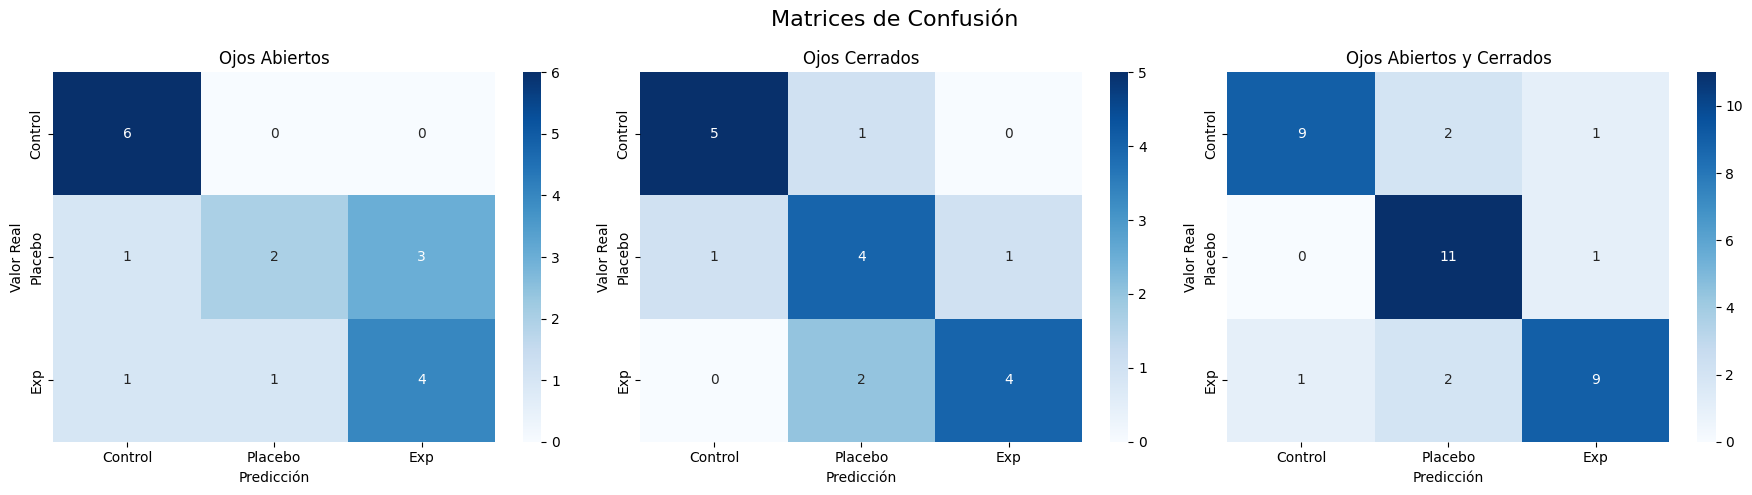

Best parameters: {'C': 0.8, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.67

Best parameters: {'C': 0.4, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.72

Best parameters: {'C': 0.2, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 0.81


In [21]:
# Combinamos los 3 inputs en un diccionario y se introduce al modelo LogReg()
dict_datasets = {"oa":[X_oa, y_oa],
                 "oc":[X_oc, y_oc],
                 "oa_oc":[X_oa_oc, y_oa_oc]}


report = ML.plot_log_reg(dict_datasets, class_names = ['Control', 'Placebo', 'Exp'], title = "Matrices de Confusión", subtitle = ["Ojos Abiertos", "Ojos Cerrados", "Ojos Abiertos y Cerrados"])

print("Best parameters:",report["oa"]['best_params'])
print("Accuracy:", round(report["oa"]['accuracy'],2))
print()
print("Best parameters:",report["oc"]['best_params'])
print("Accuracy:", round(report["oc"]['accuracy'],2))
print()
print("Best parameters:",report["oa_oc"]['best_params'])
print("Accuracy:", round(report["oa_oc"]['accuracy'],2))

**¡Razonamiento!**

La dinámica cerebral en estado de reposo cambia entre ojos abiertos y cerrados. Aunque en ambos casos el cerebro no está realizando una tarea específica, los patrones de actividad neuronal son distintos. Por ejemplo, el grupo control podría tener un comportamiento X en ojos abiertos, mientras que en ojos cerrados ocurre lo contrario. Puede ser una justificación de por qué la clasificación no es tan precisa como si se hiciera por separado.

## Bandas de frecuencia

In [22]:
class_names = ['Control', 'Placebo', 'Exp']
summary = pd.DataFrame([], columns=["tipo","banda","OA","OC","OA_OC"])

for i in range(len(bands)):
    # Gather all .csv files from each path
    all_temp_oa_csv, all_spec_oa_csv = Utils.get_files(data_OA_paths[0]+"\\"+bands[i]), Utils.get_files(data_OA_paths[1]+"\\"+bands[i])
    all_temp_oc_csv, all_spec_oc_csv = Utils.get_files(data_OC_paths[0]+"\\"+bands[i]), Utils.get_files(data_OC_paths[1]+"\\"+bands[i])

    # Loading all information by concatenating PRE, POST, and SEG DataFrames
    df_temp_oa, df_spec_oa = Utils.read_file_csv(all_temp_oa_csv), Utils.read_file_csv(all_spec_oa_csv)
    df_temp_oc, df_spec_oc = Utils.read_file_csv(all_temp_oc_csv), Utils.read_file_csv(all_spec_oc_csv)

    # Reset info columns order -> Movemos la columna "Var" hacia el final
    df_temp_oa, df_spec_oa = Utils.reset_cols_order(df_temp_oa, N=4), Utils.reset_cols_order(df_spec_oa, N=4)
    df_temp_oc, df_spec_oc = Utils.reset_cols_order(df_temp_oc, N=4), Utils.reset_cols_order(df_spec_oc, N=4)

    # Rename features for both domains -> Colocamos 't' o 's' dependiendo del dominio
    df_temp_oa, df_spec_oa = Utils.rename_feats(df_temp_oa, nCol=4, val="t"), Utils.rename_feats(df_spec_oa, nCol=4, val="s")
    df_temp_oc, df_spec_oc = Utils.rename_feats(df_temp_oc, nCol=4, val="t"), Utils.rename_feats(df_spec_oc, nCol=4, val="s")

    N = len(df_temp_oa.columns[4:])

    # Realizamos un join usando las 4 primeras columnas como clave 
    df_oa = pd.merge(df_temp_oa, df_spec_oa, on=list(df_temp_oa.columns)[:-N], how='inner')
    df_oc = pd.merge(df_temp_oc, df_spec_oc, on=list(df_temp_oc.columns)[:-N], how='inner')

    # Rename subjects for PLACEBO group
    df_oa, df_oc = Utils.rename_subjects(df_oa, ids_placebos), Utils.rename_subjects(df_oc, ids_placebos)

    # Remove noisy subjects
    df_oa, df_oc  = Utils.remove_subjects(df_oa, ids_oa_removal), Utils.remove_subjects(df_oc, ids_oc_removal)

    # Añadimos una columna 'tipo' que refleje si son datos de ojos abiertos (OA) o cerrados (OC).
    df_oa = Utils.add_column(df_oa, col_name="tipo", val="OA", idx=0)
    df_oc = Utils.add_column(df_oc, col_name="tipo", val="OC", idx=0)

# Nota: debo optimizar las siguientes líneas
# -------------------------------------------------------------------------------------------------------------
    d_avg_sub = {**avg_subject.get(df_oa, df_oc), **avg_subject.combine(df_oa, df_oc)}
    
    d_avg_comp = {**avg_comp.get(df_oa, df_oc), **avg_comp.combine(df_oa, df_oc)}

    scores_avg_sub = [
        round(ML.perform_log_reg(X, y, class_names)["info"]["accuracy"],2) for X, y in d_avg_sub.values()
    ]

    scores_avg_comp = [
        round(ML.perform_log_reg(X, y, class_names)["info"]["accuracy"],2) for X, y in d_avg_comp.values()
    ]
# -------------------------------------------------------------------------------------------------------------
    
    summary.loc[len(summary)] = ["avg_subject", bands[i]] + scores_avg_sub
    summary.loc[len(summary)] = ["avg_component", bands[i]] + scores_avg_comp

In [23]:
summary[summary["tipo"]=="avg_subject"]

,tipo,banda,OA,OC,OA_OC
0,avg_subject,all,0.38,0.41,0.35
2,avg_subject,delta,0.31,0.37,0.38
4,avg_subject,theta,0.35,0.33,0.35
6,avg_subject,alpha,0.38,0.41,0.35
8,avg_subject,beta,0.35,0.33,0.38
10,avg_subject,d_t_a,0.35,0.41,0.38
12,avg_subject,t_a,0.38,0.30,0.38
14,avg_subject,a_b,0.42,0.41,0.46


In [24]:
summary[summary["tipo"]=="avg_component"]

,tipo,banda,OA,OC,OA_OC
1,avg_component,all,0.67,0.72,0.81
3,avg_component,delta,0.67,0.50,0.67
5,avg_component,theta,0.67,0.67,0.75
7,avg_component,alpha,0.50,0.56,0.50
9,avg_component,beta,0.72,0.67,0.72
11,avg_component,d_t_a,0.67,0.72,0.75
13,avg_component,t_a,0.50,0.56,0.58
15,avg_component,a_b,0.44,0.67,0.64


----------------------------

---------------------